In [1]:
import networkx as nx
import igraph
import pandas as pd
import pylab as plt
import numpy as np
import Bio
import seaborn as sns

In [2]:
print(Bio.__version__)

1.79


In [55]:
plt.rcParams["figure.figsize"] = 7, 6
sns.set_style("whitegrid")

# age gene classes из Liebeskind

Скачать [age gene classes](https://github.com/marcottelab/Gene-Ages) из Liebeskind et. al. 2016, и замапить их на наши сети.

In [99]:
yeast_data = pd.read_csv('../data/yeast.txt', sep='\t')
print(yeast_data.shape)

yeast_graph = nx.from_pandas_edgelist(yeast_data, source='Tf', target='Tg', create_using=nx.DiGraph())

print('# of edges: {}'.format(yeast_graph.number_of_edges()))
print('# of nodes: {}'.format(yeast_graph.number_of_nodes()))


(12873, 2)
# of edges: 12873
# of nodes: 4441


In [5]:
mouse_data = pd.read_csv('../data/trrust_rawdata.mouse.tsv', 
                         sep='\t', header=None, 
                         names=['TF', 'Target', 'Mode', 'PMID'])
print(mouse_data.shape)

mouse_graph = nx.from_pandas_edgelist(mouse_data, 'TF', 'Target', ['Mode', 'PMID'], create_using=nx.DiGraph())
print('# of edges: {}'.format(mouse_graph.number_of_edges()))
print('# of nodes: {}'.format(mouse_graph.number_of_nodes()))

(7057, 4)
# of edges: 6490
# of nodes: 2456


In [6]:
human_data = pd.read_csv('../data/trrust_rawdata.human.tsv', 
                         sep='\t', header=None, 
                         names=['TF', 'Target', 'Mode', 'PMID'])
print(human_data.shape)

human_graph = nx.from_pandas_edgelist(human_data, 'TF', 'Target', ['Mode', 'PMID'], create_using=nx.DiGraph())

print('# of edges: {}'.format(human_graph.number_of_edges()))
print('# of nodes: {}'.format(human_graph.number_of_nodes()))

(9396, 4)
# of edges: 8427
# of nodes: 2862


# Для начала можно просто посчитать количество пар TF-TG для каждого класса, нормированное на общее количество линков.



## Import classes from [Gene-Ages/Main/](https://github.com/marcottelab/Gene-Ages/tree/master/Main)

### Yeast

In [100]:
yeast_classes = pd.read_csv('../data/main_YEAST.csv')
print(yeast_classes.shape)
yeast_classes = yeast_classes.rename(columns={"Unnamed: 0": "Protein"})
yeast_classes.head()

(5000, 16)


,Protein,Cellular_organisms,Euk_Archaea,Euk+Bac,Eukaryota,Opisthokonta,Dikarya,Ascomycota,Saccharomyceta,modeAge,NumDBsContributing,NumDBsFiltered,entropy,NodeError,Bimodality,HGT_flag
0,A2P2R3,0.800,0.0,0.2,0.000000,0.0,0.000000,0.0,0.000000,Cellular_organisms,5,1,0.500402,0.0,0.000000,False
1,D6VTK4,0.000,0.0,0.0,0.000000,0.0,0.000000,0.9,0.100000,Ascomycota,10,0,0.325083,0.2,0.107143,False
2,D6W196,0.000,0.0,0.0,0.500000,0.0,0.300000,0.0,0.200000,Eukaryota,10,2,1.029653,2.86363636364,2.236866,False
3,O13297,0.000,0.0,0.0,0.272727,0.0,0.454545,0.0,0.272727,Dikarya,11,0,1.067090,2.94545454545,0.120000,False
4,O13516,0.375,0.5,0.0,0.125000,0.0,0.000000,0.0,0.000000,Euk_Archaea,8,1,0.974315,0.777777777778,-0.220779,False


In [101]:
# for uniprot mapping - https://www.uniprot.org/uploadlists/

yeast_ID_UniProt = list(yeast_classes['Protein'])

with open('../data/age_classes/yeast_ID_UniProt.txt', 'w') as f:
    for el in yeast_ID_UniProt:
        f.write(el+' ')

 ... https://www.uniprot.org/uploadlists/ ...

In [87]:
yeast_prot_genes_UNI = pd.read_csv('../data/age_classes/Yeast_UniProtMapping.txt',
                                  sep='\t',
                                  engine='python',
                                  names=['Protein', 'Gene'],
                                  header=1)
yeast_prot_genes_UNI.head()

,Protein,Gene
0,D6VTK4,STE2
1,D6W196,SAL1
2,O13297,CET1
3,O13516,RPS9A
4,O13525,COQ4


> Через юнипрот находит слишком мало совпадений, попробуем через https://yeastmine.yeastgenome.org/yeastmine/begin.do.

No matches found: 
1. P43546 
2. P0CD89 
3. P0CD92

In [103]:
yeast_prot_genes = pd.read_csv('../data/yeast_org_db/summary.csv', sep=' ')
yeast_prot_genes = yeast_prot_genes[['input', 'secondaryIdentifier']]
yeast_prot_genes = yeast_prot_genes.rename(columns = {'input':'Protein', 'secondaryIdentifier':'Gene'})

yeast_prot_genes.head()

,Protein,Gene
0,P53266,YGR112W
1,P38885,YHR199C
2,P14693,YHR083W
3,P40042,YER066W
4,P38990,YER129W


In [104]:
yeast_classes = yeast_classes.merge(yeast_prot_genes, how='outer', on=['Protein'])
yeast_classes.head()

,Protein,Cellular_organisms,Euk_Archaea,Euk+Bac,Eukaryota,Opisthokonta,Dikarya,Ascomycota,Saccharomyceta,modeAge,NumDBsContributing,NumDBsFiltered,entropy,NodeError,Bimodality,HGT_flag,Gene
0,A2P2R3,0.800,0.0,0.2,0.000000,0.0,0.000000,0.0,0.000000,Cellular_organisms,5,1,0.500402,0.0,0.000000,False,YMR084W
1,D6VTK4,0.000,0.0,0.0,0.000000,0.0,0.000000,0.9,0.100000,Ascomycota,10,0,0.325083,0.2,0.107143,False,YFL026W
2,D6W196,0.000,0.0,0.0,0.500000,0.0,0.300000,0.0,0.200000,Eukaryota,10,2,1.029653,2.86363636364,2.236866,False,YNL083W
3,O13297,0.000,0.0,0.0,0.272727,0.0,0.454545,0.0,0.272727,Dikarya,11,0,1.067090,2.94545454545,0.120000,False,YPL228W
4,O13516,0.375,0.5,0.0,0.125000,0.0,0.000000,0.0,0.000000,Euk_Archaea,8,1,0.974315,0.777777777778,-0.220779,False,YPL081W


In [105]:
yeast_classes.shape

(5000, 17)

In [106]:
yest_TFTG = set(list(yeast_data.Tf) + list(yeast_data.Tg))

In [107]:
len(yest_TFTG)

4441

In [108]:
yeast_gene_ages = yeast_classes.query('Gene in @yest_TFTG')
#yeast_gene_ages = yeast_gene_ages[['Gene', 'modeAge']]
print(yeast_gene_ages.shape)
yeast_gene_ages.head()

(3437, 17)


,Protein,Cellular_organisms,Euk_Archaea,Euk+Bac,Eukaryota,Opisthokonta,Dikarya,Ascomycota,Saccharomyceta,modeAge,NumDBsContributing,NumDBsFiltered,entropy,NodeError,Bimodality,HGT_flag,Gene
0,A2P2R3,0.800,0.0,0.200000,0.000000,0.0,0.000000,0.0,0.000000,Cellular_organisms,5,1,0.500402,0.0,0.000000,False,YMR084W
1,D6VTK4,0.000,0.0,0.000000,0.000000,0.0,0.000000,0.9,0.100000,Ascomycota,10,0,0.325083,0.2,0.107143,False,YFL026W
3,O13297,0.000,0.0,0.000000,0.272727,0.0,0.454545,0.0,0.272727,Dikarya,11,0,1.067090,2.94545454545,0.120000,False,YPL228W
4,O13516,0.375,0.5,0.000000,0.125000,0.0,0.000000,0.0,0.000000,Euk_Archaea,8,1,0.974315,0.777777777778,-0.220779,False,YPL081W
5,O13525,0.000,0.0,0.384615,0.538462,0.0,0.000000,0.0,0.076923,Eukaryota,13,0,0.898137,2.07692307692,0.091270,False,YDR204W


#### Add New info to Graf:

In [109]:
yeast_attrs = yeast_gene_ages[['Gene', 'modeAge']].set_index('Gene').T.to_dict('dict')
nx.set_node_attributes(yeast_graph, yeast_attrs) 

In [110]:
yeast_gene_ages.groupby('modeAge').count().Gene

modeAge
Ascomycota             111
Cellular_organisms     372
Dikarya                241
Euk+Bac                505
Euk_Archaea            104
Eukaryota             1364
Opisthokonta           186
Saccharomyceta         554
Name: Gene, dtype: int64

In [111]:
selected_nodes = [n for n,v in yeast_graph.nodes(data=True) if v]
selected_edges = [(u, v) for u, v, e in yeast_graph.edges(data=True) if u in selected_nodes or v in selected_nodes]

In [112]:
H = nx.DiGraph(((u, v, e) for u,v,e in yeast_graph.edges(data=True) if u in selected_nodes or v in selected_nodes))
nx.set_node_attributes(H, yeast_attrs)

In [113]:
color_map = []

color_dict = {'Ascomycota': 'tab:blue', 'Cellular_organisms': 'tab:green',
              'Dikarya': 'gold', 'Euk+Bac': 'tab:red',
              'Euk_Archaea': 'tab:pink', 'Eukaryota': 'tab:olive',
              'Opisthokonta': 'tab:cyan', 'Saccharomyceta': 'red'}

for node in H.nodes(data=True):
    
    if node[1].get('modeAge') in color_dict.keys():
        color_map.append(color_dict[node[1].get('modeAge')])
    
    else: 
        color_map.append('ivory')

In [114]:
plt.figure(figsize=(50, 50))
pos = nx.bipartite_layout(H, selected_nodes)
nx.draw_networkx_nodes(H, pos, node_color=color_map)
nx.draw_networkx_edges(H, pos)

#plt.show()
plt.savefig('../data/02_plots/plot_01.png')
plt.close()

In [115]:
plt.figure(figsize=(50, 50))
pos = nx.circular_layout(H)

nx.draw_networkx_nodes(H, pos, node_color=color_map)
nx.draw_networkx_edges(H, pos)

#plt.show()
plt.savefig('../data/02_plots/plot_02.png')
plt.close()

In [116]:
tf_ages_list = []
tg_ages_list = []

for i in yeast_data.Tf:
    if list(yeast_gene_ages.loc[yeast_gene_ages['Gene'] == i]['modeAge']):
        tf_ages_list.append(yeast_gene_ages.loc[yeast_gene_ages['Gene'] == i]['modeAge'].iloc[0])
        
    else:
        tf_ages_list.append(np.nan)

for i in yeast_data.Tg:
    if list(yeast_gene_ages.loc[yeast_gene_ages['Gene'] == i]['modeAge']):
        tg_ages_list.append(yeast_gene_ages.loc[yeast_gene_ages['Gene'] == i]['modeAge'].iloc[0])
    else:
        tg_ages_list.append(np.nan)

In [117]:
yeast_data['TF_age'] = tf_ages_list
yeast_data['Tg_age'] = tg_ages_list

In [118]:
yeast_data

,Tf,Tg,TF_age,Tg_age
0,YAL051W,YAL016W,Saccharomyceta,Eukaryota
1,YAL051W,YAL034WA,Saccharomyceta,NaN
2,YAL051W,YAL035CA,Saccharomyceta,NaN
3,YAL051W,YAL035W,Saccharomyceta,Euk_Archaea
4,YAL051W,YAL036C,Saccharomyceta,Cellular_organisms
...,...,...,...,...
12868,YPR199C,YML048WA,NaN,NaN
12869,YPR199C,YMR086CA,NaN,NaN
12870,YPR199C,YMR087W,NaN,Saccharomyceta
12871,YPR199C,YMR135WA,NaN,NaN


In [119]:
# проверим, можем ли мы добавить что-то из UNIPROT:

no_TF_info = set(list(yeast_data[yeast_data.TF_age.isna()].Tf))
no_Tg_info = set(list(yeast_data[yeast_data.Tg_age.isna()].Tg))

In [120]:
print(len(no_TF_info))
print(len(no_Tg_info))

13
1001


In [121]:
yeast_prot_genes_UNI.query('Gene in @no_TF_info')

,Protein,Gene


In [122]:
yeast_prot_genes_UNI.query('Gene in @no_Tg_info')

,Protein,Gene
2666,P43546,YFL057C


In [123]:
yeast_gene_ages[yeast_gene_ages.Protein == 'P43546']

,Protein,Cellular_organisms,Euk_Archaea,Euk+Bac,Eukaryota,Opisthokonta,Dikarya,Ascomycota,Saccharomyceta,modeAge,NumDBsContributing,NumDBsFiltered,entropy,NodeError,Bimodality,HGT_flag,Gene


> не вышло

In [124]:
# сохраним датафрейм
yeast_data.to_csv('../data/yeast_classes.csv')

In [125]:
# Есть связи, где классы нод не совпадают
yeast_data[yeast_data['TF_age'].notnull() & yeast_data['Tg_age'].notnull()]

,Tf,Tg,TF_age,Tg_age
0,YAL051W,YAL016W,Saccharomyceta,Eukaryota
3,YAL051W,YAL035W,Saccharomyceta,Euk_Archaea
4,YAL051W,YAL036C,Saccharomyceta,Cellular_organisms
5,YAL051W,YBL089W,Saccharomyceta,Eukaryota
6,YAL051W,YBR019C,Saccharomyceta,Cellular_organisms
...,...,...,...,...
12838,YPR104C,YPR042C,Opisthokonta,Eukaryota
12841,YPR104C,YPR102C,Opisthokonta,Euk_Archaea
12842,YPR104C,YPR103W,Opisthokonta,Euk_Archaea
12843,YPR104C,YPR131C,Opisthokonta,Eukaryota


In [126]:
yeast_data['age'] = yeast_data["TF_age"].fillna('') + yeast_data["Tg_age"].fillna('')
yeast_data['age'].replace('', np.nan, inplace=True)
yeast_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12873 entries, 0 to 12872
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Tf      12873 non-null  object
 1   Tg      12873 non-null  object
 2   TF_age  12391 non-null  object
 3   Tg_age  9678 non-null   object
 4   age     12696 non-null  object
dtypes: object(5)
memory usage: 503.0+ KB


Подсчитаем сколько связей каждого класса:

In [45]:
yeast_data.groupby('age', as_index=False).count()

,age,Tf,Tg,TF_age,Tg_age
0,Ascomycota,108,108,94,14
1,AscomycotaAscomycota,4,4,4,4
2,AscomycotaCellular_organisms,58,58,58,58
3,AscomycotaDikarya,26,26,26,26
4,AscomycotaEuk+Bac,65,65,65,65
5,AscomycotaEuk_Archaea,5,5,5,5
6,AscomycotaEukaryota,79,79,79,79
7,AscomycotaOpisthokonta,6,6,6,6
8,AscomycotaSaccharomyceta,35,35,35,35
9,Cellular_organisms,32,32,0,32


In [46]:
yeast_data[['age']].value_counts()

age                             
SaccharomycetaEukaryota             1238
Saccharomyceta                      1113
Opisthokonta                         936
OpisthokontaEukaryota                915
SaccharomycetaEuk+Bac                608
EukaryotaEukaryota                   585
DikaryaEukaryota                     580
Dikarya                              562
SaccharomycetaSaccharomyceta         552
Eukaryota                            519
OpisthokontaSaccharomyceta           480
SaccharomycetaCellular_organisms     466
OpisthokontaEuk+Bac                  389
OpisthokontaCellular_organisms       282
DikaryaSaccharomyceta                271
EukaryotaSaccharomyceta              251
SaccharomycetaDikarya                245
DikaryaEuk+Bac                       235
EukaryotaEuk+Bac                     197
OpisthokontaDikarya                  186
SaccharomycetaOpisthokonta           176
DikaryaCellular_organisms            174
EukaryotaCellular_organisms          159
OpisthokontaOpisthokonta

In [47]:
# Доля классов с учетом всех связей
yeast_data[['age']].value_counts(normalize=True, dropna=False)

age                             
SaccharomycetaEukaryota             0.096170
Saccharomyceta                      0.086460
Opisthokonta                        0.072710
OpisthokontaEukaryota               0.071079
SaccharomycetaEuk+Bac               0.047231
EukaryotaEukaryota                  0.045444
DikaryaEukaryota                    0.045056
Dikarya                             0.043657
SaccharomycetaSaccharomyceta        0.042880
Eukaryota                           0.040317
OpisthokontaSaccharomyceta          0.037287
SaccharomycetaCellular_organisms    0.036200
OpisthokontaEuk+Bac                 0.030218
OpisthokontaCellular_organisms      0.021906
DikaryaSaccharomyceta               0.021052
EukaryotaSaccharomyceta             0.019498
SaccharomycetaDikarya               0.019032
DikaryaEuk+Bac                      0.018255
EukaryotaEuk+Bac                    0.015303
OpisthokontaDikarya                 0.014449
NaN                                 0.013750
SaccharomycetaOpisthok

In [48]:
# Доля классов среди известных классов
yeast_data[['age']].value_counts(normalize=True)

age                             
SaccharomycetaEukaryota             0.097511
Saccharomyceta                      0.087665
Opisthokonta                        0.073724
OpisthokontaEukaryota               0.072070
SaccharomycetaEuk+Bac               0.047889
EukaryotaEukaryota                  0.046078
DikaryaEukaryota                    0.045684
Dikarya                             0.044266
SaccharomycetaSaccharomyceta        0.043478
Eukaryota                           0.040879
OpisthokontaSaccharomyceta          0.037807
SaccharomycetaCellular_organisms    0.036704
OpisthokontaEuk+Bac                 0.030640
OpisthokontaCellular_organisms      0.022212
DikaryaSaccharomyceta               0.021345
EukaryotaSaccharomyceta             0.019770
SaccharomycetaDikarya               0.019297
DikaryaEuk+Bac                      0.018510
EukaryotaEuk+Bac                    0.015517
OpisthokontaDikarya                 0.014650
SaccharomycetaOpisthokonta          0.013863
DikaryaCellular_organi

In [49]:
ax = (yeast_data[['age']].value_counts(normalize=True)  * 100).plot.barh()

for container in ax.containers:
    ax.bar_label(container, fmt='%.1f%%')

plt.savefig('../data/02_plots/plot_03.png')
plt.close()


##### heatmap

In [127]:
yeast_data.TF_age.value_counts()

Saccharomyceta    4552
Opisthokonta      3501
Dikarya           2085
Eukaryota         1876
Ascomycota         372
Euk+Bac              5
Name: TF_age, dtype: int64

In [128]:
yeast_data.Tg_age.value_counts()

Eukaryota             3493
Saccharomyceta        1652
Euk+Bac               1543
Cellular_organisms    1172
Dikarya                701
Opisthokonta           487
Ascomycota             330
Euk_Archaea            300
Name: Tg_age, dtype: int64

In [129]:
# heatmap

# Substituting nans with "no info"
yeast_data[['Tg_age', 'TF_age']] = yeast_data[['Tg_age', 'TF_age']].replace(np.nan, 'no info')

In [130]:
heatmap_y = pd.crosstab(yeast_data.TF_age, yeast_data.Tg_age)
heatmap_y

Tg_age,Ascomycota,Cellular_organisms,Dikarya,Euk+Bac,Euk_Archaea,Eukaryota,Opisthokonta,Saccharomyceta,no info
TF_age,,,,,,,,,
Ascomycota,4,58,26,65,5,79,6,35,94
Dikarya,52,174,101,235,55,580,84,271,533
Euk+Bac,0,1,0,3,0,0,0,1,0
Eukaryota,43,159,114,197,35,585,69,251,423
Opisthokonta,96,282,186,389,103,915,133,480,917
Saccharomyceta,121,466,245,608,95,1238,176,552,1051
no info,14,32,29,46,7,96,19,62,177


Text(0.5, 1.0, 'Age classes heatmap, yeast')

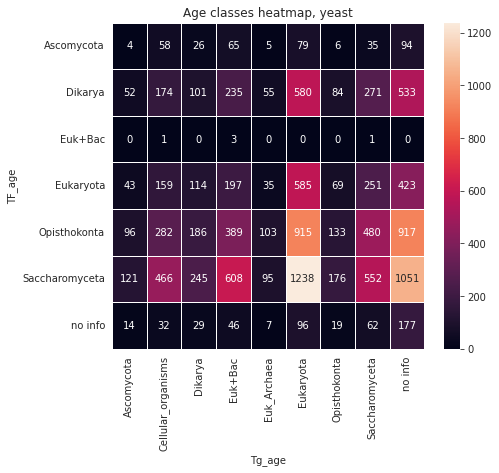

In [131]:
plt.rcParams["figure.figsize"] = 7, 6

sns.heatmap(heatmap_y, annot=True, linewidths=0.5, fmt='g')
plt.title('Age classes heatmap, yeast')

In [57]:
sns.heatmap(heatmap_y, annot=True, linewidths=0.5, fmt='g')
plt.title('Age classes heatmap, yeast')
plt.savefig('../data/02_plots/yeast_heatmap_01.png')
plt.close()

##### установление возраста связи по самому молодому узлу

In [132]:
# установление возраста связи по самому молодому узлу
classes = ['no info', 'Cellular_organisms', 'Euk_Archaea','Euk+Bac', 'Eukaryota',
           'Opisthokonta', 'Dikarya', 'Ascomycota', 'Saccharomyceta']

yeast_data['Tg_age'] = yeast_data['Tg_age'].apply(lambda x: classes.index(x))
yeast_data['TF_age'] = yeast_data['TF_age'].apply(lambda x: classes.index(x))

In [133]:
yeast_data['age_max'] = np.where(yeast_data['TF_age'] > yeast_data['Tg_age'], 
                                 yeast_data['TF_age'],
                                 yeast_data['Tg_age'])

In [134]:
# перевод обратно в названия классов
yeast_data['age_max'] = yeast_data['age_max'].apply(lambda x: classes[x])

In [135]:
# no info to NAN
yeast_data['age_max'] = yeast_data['age_max'].replace({'no info': np.nan})

In [136]:
# Доля классов (по молодому) с учетом всех связей
yeast_data[['age_max']].value_counts(normalize=True, dropna=False)

age_max           
Saccharomyceta        0.439058
Opisthokonta          0.219607
Dikarya               0.162433
Eukaryota             0.116135
Ascomycota            0.042104
NaN                   0.013750
Euk+Bac               0.003884
Cellular_organisms    0.002486
Euk_Archaea           0.000544
dtype: float64

In [137]:
# Доля классов среди известных классов (по молодому)
yeast_data[['age_max']].value_counts(normalize=True)

age_max           
Saccharomyceta        0.445180
Opisthokonta          0.222669
Dikarya               0.164698
Eukaryota             0.117754
Ascomycota            0.042691
Euk+Bac               0.003938
Cellular_organisms    0.002520
Euk_Archaea           0.000551
dtype: float64

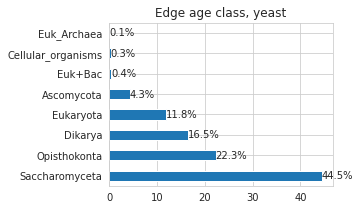

In [729]:
plt.rcParams["figure.figsize"] = 4, 3

ax = (yeast_data['age_max'].value_counts(normalize=True) * 100).plot.barh()

plt.title('Edges age class, yeast')
for container in ax.containers:
    ax.bar_label(container, fmt='%.1f%%')

In [730]:
ax = (yeast_data['age_max'].value_counts(normalize=True) * 100).plot.barh()

for container in ax.containers:
    ax.bar_label(container, fmt='%.1f%%')

plt.title('Age (from most recent node), yeast')
plt.savefig('../data/02_plots/plot_10.png')
plt.close()

Text(0.5, 1.0, 'Edge Age (from most recent node), yeast')

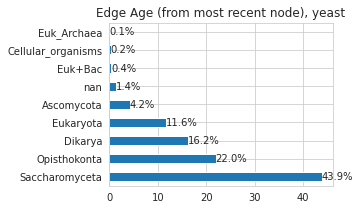

In [732]:
ax = (yeast_data['age_max'].value_counts(normalize=True, dropna=False) * 100).plot.barh()

for container in ax.containers:
    ax.bar_label(container, fmt='%.1f%%')

plt.title('Edge Age (from most recent node), yeast')

In [143]:
ax = (yeast_data['age_max'].value_counts(normalize=True, dropna=False) * 100).plot.barh()

for container in ax.containers:
    ax.bar_label(container, fmt='%.1f%%')

plt.title('Age (from most recent node), yeast')
plt.savefig('../data/02_plots/plot_11.png')
plt.close()

##### установление возраста связи по среднему возрасту между узлами
если один из участников неизвестен - присваиваем ребру возраст известного

In [156]:
# + 0.1 use for math round

yeast_data['age_mean'] = np.where((yeast_data['TF_age'] == 0) | (yeast_data['Tg_age'] == 0),
                                  yeast_data[['TF_age', 'Tg_age']].max(axis=1),
                                  (yeast_data['TF_age'] + yeast_data['Tg_age'] + 0.1) / 2)

In [157]:
# float to int
yeast_data['age_mean'] = yeast_data['age_mean'].round().astype('int64')

In [158]:
# перевод обратно в названия классов
yeast_data['age_mean'] = yeast_data['age_mean'].apply(lambda x: classes[x])

# no info to NAN
yeast_data['age_mean'] = yeast_data['age_mean'].replace({'no info': np.nan})

In [159]:
# Доля классов (по среднему) с учетом всех связей
yeast_data[['age_mean']].value_counts(normalize=True, dropna=False)

age_mean          
Opisthokonta          0.280665
Dikarya               0.252855
Eukaryota             0.161578
Saccharomyceta        0.141459
Ascomycota            0.105803
Euk+Bac               0.040783
NaN                   0.013750
Cellular_organisms    0.002486
Euk_Archaea           0.000621
dtype: float64

In [153]:
# Доля классов среди известных классов (по молодому)
yeast_data[['age_mean']].value_counts(normalize=True)

age_mean          
Opisthokonta          0.284578
Dikarya               0.256380
Eukaryota             0.163831
Saccharomyceta        0.143431
Ascomycota            0.107278
Euk+Bac               0.041352
Cellular_organisms    0.002520
Euk_Archaea           0.000630
dtype: float64

Text(0.5, 1.0, 'Age (from node mean), yeast')

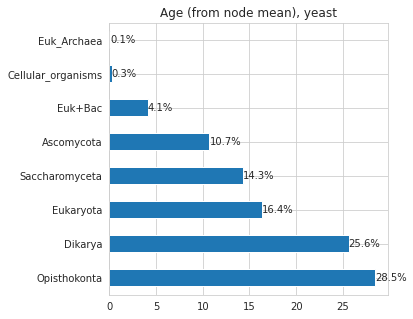

In [162]:
ax = (yeast_data['age_mean'].value_counts(normalize=True) * 100).plot.barh()

for container in ax.containers:
    ax.bar_label(container, fmt='%.1f%%')

plt.title('Age (from node mean), yeast')


In [ ]:
ax = (yeast_data['age_mean'].value_counts(normalize=True) * 100).plot.barh()

for container in ax.containers:
    ax.bar_label(container, fmt='%.1f%%')

plt.title('Age (from node mean), yeast')
plt.savefig('../data/02_plots/plot_12.png')
plt.close()

Text(0.5, 1.0, 'Age (from node mean), yeast')

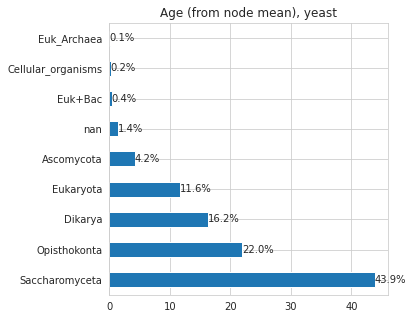

In [163]:
ax = (yeast_data['age_max'].value_counts(normalize=True, dropna=False) * 100).plot.barh()

for container in ax.containers:
    ax.bar_label(container, fmt='%.1f%%')

plt.title('Age (from node mean), yeast')


In [ ]:
ax = (yeast_data['age_max'].value_counts(normalize=True, dropna=False) * 100).plot.barh()

for container in ax.containers:
    ax.bar_label(container, fmt='%.1f%%')

plt.title('Age (from node mean), yeast')
plt.savefig('../data/02_plots/plot_13.png')
plt.close()

##### Длина связи (в единицах разницы между возрастами узлов)

In [183]:
yeast_data['age_length'] = np.where((yeast_data['TF_age'] == 0) | (yeast_data['Tg_age'] == 0),
                                     -1,
                                     abs(yeast_data['TF_age'] - yeast_data['Tg_age']))

# no info to NAN
yeast_data['age_length'] = yeast_data['age_length'].replace({-1: np.nan})

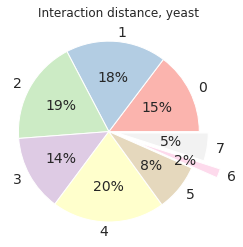

In [735]:
plt.rcParams["figure.figsize"] = 4, 4

idx = [0, 1, 2, 3, 4, 5, 6, 7]
counts = pd.Series(yeast_data['age_length'].value_counts(normalize=True) * 100)
counts.index = counts.index.astype('int64')
counts = counts[idx]

explode = (0, 0, 0, 0, 0, 0, 0.3, 0.1)
counts.plot(kind='pie', fontsize=14, colormap="Pastel1", explode=explode,  autopct='%.0f%%')
plt.axis('equal')
plt.ylabel('')
plt.title('Interaction distance, yeast')
#plt.legend(labels=counts.index, loc="best")
plt.show()
plt.savefig('../data/02_plots/ID_01.png')
plt.close()

### Mouse

In [296]:
mouse_classes = pd.read_csv('../data/main_MOUSE.csv')
print(mouse_classes.shape)
mouse_classes = mouse_classes.rename(columns={"Unnamed: 0": "Protein"})
mouse_classes.head()

(19950, 16)


,Protein,Cellular_organisms,Euk_Archaea,Euk+Bac,Eukaryota,Opisthokonta,Eumetazoa,Vertebrata,Mammalia,modeAge,NumDBsContributing,NumDBsFiltered,entropy,NodeError,Bimodality,HGT_flag
0,A0A0A0MQ97,0.000000,0.000000,0.000000,0.0,0.0,0.375000,0.625000,0.000000,Vertebrata,8,5,0.661563,3.33333333333,1.599206,False
1,A0A0A0MQB3,0.333333,0.083333,0.333333,0.0,0.0,0.250000,0.000000,0.000000,Cellular_organisms,12,0,1.286057,3.24242424242,-0.166667,True
2,A0A0A0MQC1,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.800000,0.200000,Vertebrata,5,1,0.500402,1.0,NaN,False
3,A0A0A0MQF7,0.000000,0.000000,0.000000,0.0,0.0,1.000000,0.000000,0.000000,Eumetazoa,2,0,-0.000000,2.0,NaN,False
4,A0A0B4J1F6,0.000000,0.000000,0.000000,0.0,0.0,0.142857,0.428571,0.428571,Mammalia,7,5,1.004242,4.16666666667,4.400000,False


In [297]:
mouse_TFTG = set(list(mouse_data.TF) + list(mouse_data.Target))

In [298]:
len(mouse_TFTG)

2456

In [299]:
# for uniprot mapping - https://www.uniprot.org/uploadlists/

mouse_ID_UniProt = list(mouse_classes['Protein'])

with open('../data/age_classes/mouse_ID_UniProt.txt', 'w') as f:
    for el in mouse_ID_UniProt:
        f.write(el+' ')

 ... https://www.uniprot.org/uploadlists/ ...

In [300]:
mouse_prot_genes = pd.read_csv('../data/age_classes/mouse_UniProtMapping.txt',
                                  sep='\t',
                                  engine='python',
                                  names=['Protein', 'Gene'],
                                  header=1)
mouse_prot_genes.head()

,Protein,Gene
0,A0A0A0MQC1,Ighv3-5
1,A0A0A0MQF7,1700025G04Rik
2,A0A0B4J1F6,BC053393
3,A0A0B4J1F8,Smim10l2a
4,A0A0B4J1F9,Tchh


In [301]:
mouse_classes = mouse_classes.merge(mouse_prot_genes, how='outer', on=['Protein'])
mouse_classes.head()

,Protein,Cellular_organisms,Euk_Archaea,Euk+Bac,Eukaryota,Opisthokonta,Eumetazoa,Vertebrata,Mammalia,modeAge,NumDBsContributing,NumDBsFiltered,entropy,NodeError,Bimodality,HGT_flag,Gene
0,A0A0A0MQ97,0.000000,0.000000,0.000000,0.0,0.0,0.375000,0.625000,0.000000,Vertebrata,8,5,0.661563,3.33333333333,1.599206,False,NaN
1,A0A0A0MQB3,0.333333,0.083333,0.333333,0.0,0.0,0.250000,0.000000,0.000000,Cellular_organisms,12,0,1.286057,3.24242424242,-0.166667,True,NaN
2,A0A0A0MQC1,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.800000,0.200000,Vertebrata,5,1,0.500402,1.0,NaN,False,Ighv3-5
3,A0A0A0MQF7,0.000000,0.000000,0.000000,0.0,0.0,1.000000,0.000000,0.000000,Eumetazoa,2,0,-0.000000,2.0,NaN,False,1700025G04Rik
4,A0A0B4J1F6,0.000000,0.000000,0.000000,0.0,0.0,0.142857,0.428571,0.428571,Mammalia,7,5,1.004242,4.16666666667,4.400000,False,BC053393


In [302]:
mouse_classes.shape

(20001, 17)

In [303]:
mouse_gene_ages = mouse_classes.query('Gene in @mouse_TFTG')
#mouse_gene_ages = mouse_gene_ages[['Gene', 'modeAge']]
print(mouse_gene_ages.shape)
mouse_gene_ages.head()

(2287, 17)


,Protein,Cellular_organisms,Euk_Archaea,Euk+Bac,Eukaryota,Opisthokonta,Eumetazoa,Vertebrata,Mammalia,modeAge,NumDBsContributing,NumDBsFiltered,entropy,NodeError,Bimodality,HGT_flag,Gene
44,A1L358,0.0,0.0,0.0,0.000000,1.0,0.000000,0.000000,0.000000,Opisthokonta,1,11,-0.000000,5.98484848485,3.577778,False,Mzf1
80,A2A5Z6,0.0,0.0,0.0,0.714286,0.0,0.142857,0.142857,0.000000,Eukaryota,7,5,0.796312,4.10606060606,4.533333,False,Smurf2
87,A2A6M5,0.0,0.0,0.0,0.090909,0.0,0.272727,0.363636,0.272727,Vertebrata,11,1,1.294545,5.37878787879,2.711111,False,Calcoco2
97,A2A7F4,0.0,0.0,0.0,0.000000,0.0,0.384615,0.615385,0.000000,Vertebrata,13,0,0.666278,1.02564102564,0.150794,False,Rlf
114,A2A863,0.0,0.0,0.0,0.000000,0.0,0.583333,0.416667,0.000000,Eumetazoa,12,1,0.679193,2.48717948718,1.988095,False,Itgb4


#### Add New info to Graf:

In [304]:
mouse_attrs = mouse_gene_ages[['Gene', 'modeAge']].set_index('Gene').T.to_dict('dict')
nx.set_node_attributes(mouse_graph, mouse_attrs) 

/tmp/ipykernel_112930/1163802281.py:1: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  mouse_attrs = mouse_gene_ages[['Gene', 'modeAge']].set_index('Gene').T.to_dict('dict')


In [305]:
mouse_gene_ages.groupby('modeAge').count().Gene

modeAge
Cellular_organisms     85
Euk+Bac               153
Euk_Archaea            20
Eukaryota             436
Eumetazoa             878
Mammalia              152
Opisthokonta          130
Vertebrata            433
Name: Gene, dtype: int64

In [306]:
selected_nodes_mouse = [n for n,v in mouse_graph.nodes(data=True) if v]
selected_edges_mouse = [(u, v) for u, v, e in mouse_graph.edges(data=True) if u in selected_nodes_mouse or v in selected_nodes_mouse]

mouse_H = nx.DiGraph(((u, v, e) for u,v,e in mouse_graph.edges(data=True) if u in selected_nodes_mouse or v in selected_nodes_mouse))
nx.set_node_attributes(mouse_H, mouse_attrs)

In [307]:
color_map_m = []

color_dict_m = {'Vertebrata': 'tab:blue', 'Cellular_organisms': 'tab:green',
                'Eumetazoa': 'gold', 'Euk+Bac': 'tab:red',
                'Euk_Archaea': 'tab:pink', 'Eukaryota': 'tab:olive',
                'Opisthokonta': 'tab:cyan', 'Mammalia': 'red'}

for node in mouse_H.nodes(data=True):
    
    if node[1].get('modeAge') in color_dict.keys():
        color_map_m.append(color_dict_m[node[1].get('modeAge')])
    
    else: 
        color_map_m.append('ivory')

In [308]:
plt.figure(figsize=(50, 50))
pos = nx.bipartite_layout(mouse_H, selected_nodes_mouse)
nx.draw_networkx_nodes(mouse_H, pos, node_color=color_map_m)
nx.draw_networkx_edges(mouse_H, pos)

#plt.show()
plt.savefig('../data/02_plots/plot_04.png')
plt.close()

In [309]:
plt.figure(figsize=(50, 50))
pos = nx.circular_layout(mouse_H)

nx.draw_networkx_nodes(mouse_H, pos, node_color=color_map_m)
nx.draw_networkx_edges(mouse_H, pos)

#plt.show()
plt.savefig('../data/02_plots/plot_05.png')
plt.close()

#### Связь-возраст

In [310]:
mtf_ages_list = []
mtg_ages_list = []

for i in mouse_data.TF:
    if list(mouse_gene_ages.loc[mouse_gene_ages['Gene'] == i]['modeAge']):
        mtf_ages_list.append(mouse_gene_ages.loc[mouse_gene_ages['Gene'] == i]['modeAge'].iloc[0])
        
    else:
        mtf_ages_list.append(None)

for i in mouse_data.Target:
    if list(mouse_gene_ages.loc[mouse_gene_ages['Gene'] == i]['modeAge']):
        mtg_ages_list.append(mouse_gene_ages.loc[mouse_gene_ages['Gene'] == i]['modeAge'].iloc[0])
    else:
        mtg_ages_list.append(None)

In [311]:
mouse_data['TF_age'] = mtf_ages_list
mouse_data['Tg_age'] = mtg_ages_list

mouse_data['TF_age'].replace('None', np.nan, inplace=True)
mouse_data['Tg_age'].replace('None', np.nan, inplace=True)

In [312]:
# сохраним датафрейм
mouse_data.to_csv('../data/trrust_rawdata.mouse_classes.csv')

In [313]:
# Есть ребра, где классы не совпадают
mouse_data[mouse_data['TF_age'] != mouse_data['Tg_age']]

,TF,Target,Mode,PMID,TF_age,Tg_age
0,Aatf,Bak1,Unknown,22983126,Eukaryota,Eumetazoa
1,Aatf,Bax,Unknown,22983126,Eukaryota,Eumetazoa
2,Aatf,Bbc3,Unknown,22983126,Eukaryota,Mammalia
3,Aatf,Cdkn1a,Unknown,21317046,Eukaryota,Eumetazoa
5,Aatf,Trp53,Activation,17157788;20708154,Eukaryota,Opisthokonta
...,...,...,...,...,...,...
7048,Zic2,Afp,Repression,16765502,Eumetazoa,Vertebrata
7053,Zic3,Nanog,Activation,20872845;23421367,Eumetazoa,Mammalia
7054,Zscan10,Nanog,Activation,17628018,Opisthokonta,Mammalia
7055,Zscan10,Pou5f1,Activation,17628018,Opisthokonta,Mammalia


In [314]:
mouse_data['TF_age'].fillna('', inplace=True)
mouse_data['Tg_age'].fillna('', inplace=True)

mouse_data["age"] = mouse_data.apply(lambda row: row["TF_age"] if row["Tg_age"] == row["TF_age"] else row["TF_age"] + row["Tg_age"], axis=1) 

In [315]:
mouse_data['age'].replace('', np.nan, inplace=True)

In [316]:
mouse_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7057 entries, 0 to 7056
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   TF      7057 non-null   object
 1   Target  7057 non-null   object
 2   Mode    7057 non-null   object
 3   PMID    7057 non-null   object
 4   TF_age  7057 non-null   object
 5   Tg_age  7057 non-null   object
 6   age     7029 non-null   object
dtypes: object(7)
memory usage: 386.1+ KB


In [317]:
mouse_data.groupby('age', as_index=False).count()

,age,TF,Target,Mode,PMID,TF_age,Tg_age
0,Cellular_organisms,23,23,23,23,23,23
1,Cellular_organismsEuk+Bac,4,4,4,4,4,4
2,Cellular_organismsEukaryota,8,8,8,8,8,8
3,Cellular_organismsEumetazoa,26,26,26,26,26,26
4,Cellular_organismsMammalia,6,6,6,6,6,6
5,Cellular_organismsOpisthokonta,3,3,3,3,3,3
6,Cellular_organismsVertebrata,16,16,16,16,16,16
7,Euk+Bac,43,43,43,43,43,43
8,Euk+BacCellular_organisms,2,2,2,2,2,2
9,Euk+BacEukaryota,5,5,5,5,5,5


In [318]:
mouse_data[['age']].value_counts()

age                           
Eumetazoa                         1888
EumetazoaVertebrata                884
EumetazoaEukaryota                 436
Vertebrata                         391
EumetazoaMammalia                  364
VertebrataEumetazoa                334
EukaryotaEumetazoa                 266
EumetazoaEuk+Bac                   242
Eukaryota                          241
EumetazoaOpisthokonta              231
OpisthokontaEumetazoa              230
EukaryotaVertebrata                149
OpisthokontaVertebrata             134
EumetazoaCellular_organisms        130
VertebrataEukaryota                120
Opisthokonta                        99
OpisthokontaEukaryota               86
VertebrataMammalia                  72
VertebrataEuk+Bac                   63
EukaryotaMammalia                   56
Mammalia                            55
EukaryotaOpisthokonta               54
OpisthokontaMammalia                52
Euk+Bac                             43
EukaryotaEuk+Bac                 

In [319]:
# Доля классов с учетом всех связей
mouse_data[['age']].value_counts(normalize=True, dropna=False)

age                           
Eumetazoa                         0.267536
EumetazoaVertebrata               0.125266
EumetazoaEukaryota                0.061783
Vertebrata                        0.055406
EumetazoaMammalia                 0.051580
VertebrataEumetazoa               0.047329
EukaryotaEumetazoa                0.037693
EumetazoaEuk+Bac                  0.034292
Eukaryota                         0.034150
EumetazoaOpisthokonta             0.032733
OpisthokontaEumetazoa             0.032592
EukaryotaVertebrata               0.021114
OpisthokontaVertebrata            0.018988
EumetazoaCellular_organisms       0.018421
VertebrataEukaryota               0.017004
Opisthokonta                      0.014029
OpisthokontaEukaryota             0.012186
VertebrataMammalia                0.010203
VertebrataEuk+Bac                 0.008927
EukaryotaMammalia                 0.007935
Mammalia                          0.007794
EukaryotaOpisthokonta             0.007652
OpisthokontaMammalia   

In [320]:
# Доля классов среди исзвестных классов
mouse_data[['age']].value_counts(normalize=True)

age                           
Eumetazoa                         0.268602
EumetazoaVertebrata               0.125765
EumetazoaEukaryota                0.062029
Vertebrata                        0.055627
EumetazoaMammalia                 0.051785
VertebrataEumetazoa               0.047517
EukaryotaEumetazoa                0.037843
EumetazoaEuk+Bac                  0.034429
Eukaryota                         0.034287
EumetazoaOpisthokonta             0.032864
OpisthokontaEumetazoa             0.032722
EukaryotaVertebrata               0.021198
OpisthokontaVertebrata            0.019064
EumetazoaCellular_organisms       0.018495
VertebrataEukaryota               0.017072
Opisthokonta                      0.014085
OpisthokontaEukaryota             0.012235
VertebrataMammalia                0.010243
VertebrataEuk+Bac                 0.008963
EukaryotaMammalia                 0.007967
Mammalia                          0.007825
EukaryotaOpisthokonta             0.007682
OpisthokontaMammalia   

In [321]:
plt.figure(figsize=(15, 15))
ax = (mouse_data[['age']].value_counts(normalize=True) * 100).plot.barh()

for container in ax.containers:
    ax.bar_label(container, fmt='%.1f%%')

plt.savefig('../data/02_plots/plot_06.png')
plt.close()

####  heatmap

In [322]:
# heatmap

# Substituting nans with "no info"
mouse_data[['Tg_age', 'TF_age']] = mouse_data[['Tg_age', 'TF_age']].replace('', 'no info')

In [323]:
heatmap_m = pd.crosstab(mouse_data.TF_age, mouse_data.Tg_age)
heatmap_m

Tg_age,Cellular_organisms,Euk+Bac,Euk_Archaea,Eukaryota,Eumetazoa,Mammalia,Opisthokonta,Vertebrata,no info
TF_age,,,,,,,,,
Cellular_organisms,3,4,0,8,26,6,3,16,3
Euk+Bac,2,0,0,5,14,2,4,12,2
Euk_Archaea,0,1,1,3,2,2,0,3,0
Eukaryota,21,42,7,112,266,56,54,149,34
Eumetazoa,130,242,13,436,1445,364,231,884,238
Mammalia,0,3,0,7,42,10,8,17,11
Opisthokonta,20,29,5,86,230,52,39,134,31
Vertebrata,16,63,3,120,334,72,38,224,62
no info,17,41,1,95,205,34,29,105,28


Text(0.5, 1.0, 'Age classes heatmap, mouse')

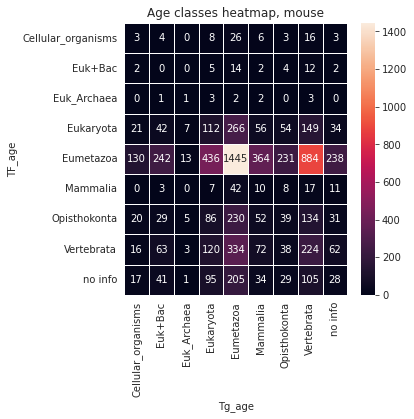

In [324]:
sns.heatmap(heatmap_m, annot=True, linewidths=0.5, fmt='g')
plt.title('Age classes heatmap, mouse')

In [325]:
sns.heatmap(heatmap_m, annot=True, linewidths=0.5, fmt='g')
plt.title('Age classes heatmap, mouse')
plt.savefig('../data/02_plots/mouse_heatmap_01.png')
plt.close()

#### установка возраста по наиболее молодому узлу

In [326]:
# установление возраста связи по самому молодому узлу
classes = ['no info', 'Cellular_organisms', 'Euk_Archaea','Euk+Bac', 'Eukaryota',
           'Opisthokonta', 'Eumetazoa', 'Vertebrata', 'Mammalia']

mouse_data['Tg_age'] = mouse_data['Tg_age'].apply(lambda x: classes.index(x))
mouse_data['TF_age'] = mouse_data['TF_age'].apply(lambda x: classes.index(x))

In [327]:
mouse_data['age_max'] = np.where(mouse_data['TF_age'] > mouse_data['Tg_age'], 
                                 mouse_data['TF_age'],
                                 mouse_data['Tg_age'])

In [328]:
# перевод обратно в названия классов
mouse_data['age_max'] = mouse_data['age_max'].apply(lambda x: classes[x])

In [329]:
# no info to NAN
mouse_data['age_max'] = mouse_data['age_max'].replace({'no info': np.nan})

In [330]:
# Доля классов (по молодому) с учетом всех связей
mouse_data[['age_max']].value_counts(normalize=True, dropna=False)

age_max           
Eumetazoa             0.492844
Vertebrata            0.306504
Mammalia              0.097208
Eukaryota             0.046337
Opisthokonta          0.042511
Euk+Bac               0.007085
NaN                   0.003968
Cellular_organisms    0.003259
Euk_Archaea           0.000283
dtype: float64

In [331]:
# Доля классов среди известных классов (по молодому)
mouse_data[['age_max']].value_counts(normalize=True)

age_max           
Eumetazoa             0.494807
Vertebrata            0.307725
Mammalia              0.097596
Eukaryota             0.046522
Opisthokonta          0.042680
Euk+Bac               0.007113
Cellular_organisms    0.003272
Euk_Archaea           0.000285
dtype: float64

Text(0.5, 1.0, 'Age (from most recent node), mouse')

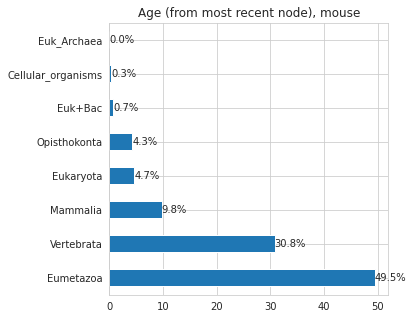

In [332]:
ax = (mouse_data['age_max'].value_counts(normalize=True) * 100).plot.barh()

for container in ax.containers:
    ax.bar_label(container, fmt='%.1f%%')

plt.title('Age (from most recent node), mouse')

In [333]:
ax = (mouse_data['age_max'].value_counts(normalize=True) * 100).plot.barh()

for container in ax.containers:
    ax.bar_label(container, fmt='%.1f%%')

plt.title('Age (from most recent node), mouse')
plt.savefig('../data/02_plots/plot_14.png')
plt.close()

Text(0.5, 1.0, 'Age (from most recent node), mouse')

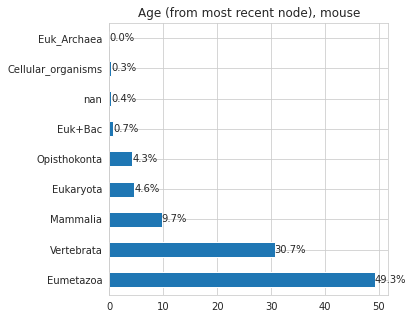

In [334]:
ax = (mouse_data['age_max'].value_counts(normalize=True, dropna=False) * 100).plot.barh()

for container in ax.containers:
    ax.bar_label(container, fmt='%.1f%%')

plt.title('Age (from most recent node), mouse')

In [335]:
ax = (mouse_data['age_max'].value_counts(normalize=True, dropna=False) * 100).plot.barh()

for container in ax.containers:
    ax.bar_label(container, fmt='%.1f%%')

plt.title('Age (from most recent node), mouse')
plt.savefig('../data/02_plots/plot_15.png')
plt.close()

##### установление возраста связи по среднему возрасту между узлами
если один из участников неизвестен - присваиваем ребру возраст известного

In [336]:
# + 0.1 use for math round

mouse_data['age_mean'] = np.where((mouse_data['TF_age'] == 0) | (mouse_data['Tg_age'] == 0),
                                  mouse_data[['TF_age', 'Tg_age']].max(axis=1),
                                  (mouse_data['TF_age'] + mouse_data['Tg_age'] + 0.1) / 2)

In [337]:
# float to int
mouse_data['age_mean'] = mouse_data['age_mean'].round().astype('int64')

In [338]:
# перевод обратно в названия классов
mouse_data['age_mean'] = mouse_data['age_mean'].apply(lambda x: classes[x])

# no info to NAN
mouse_data['age_mean'] = mouse_data['age_mean'].replace({'no info': np.nan})

In [339]:
# Доля классов (по среднему) с учетом всех связей
mouse_data[['age_mean']].value_counts(normalize=True, dropna=False)

age_mean          
Eumetazoa             0.404988
Vertebrata            0.294034
Opisthokonta          0.182230
Eukaryota             0.074961
Mammalia              0.020405
Euk+Bac               0.015021
NaN                   0.003968
Cellular_organisms    0.003259
Euk_Archaea           0.001134
dtype: float64

In [340]:
# Доля классов среди известных классов (по молодому)
mouse_data[['age_mean']].value_counts(normalize=True)

age_mean          
Eumetazoa             0.406601
Vertebrata            0.295206
Opisthokonta          0.182956
Eukaryota             0.075260
Mammalia              0.020487
Euk+Bac               0.015080
Cellular_organisms    0.003272
Euk_Archaea           0.001138
dtype: float64

In [341]:
ax = (mouse_data['age_mean'].value_counts(normalize=True) * 100).plot.barh()

for container in ax.containers:
    ax.bar_label(container, fmt='%.1f%%')

plt.title('Age (from node mean), mouse')
plt.savefig('../data/02_plots/plot_16.png')
plt.close()

Text(0.5, 1.0, 'Age (from node mean), mouse')

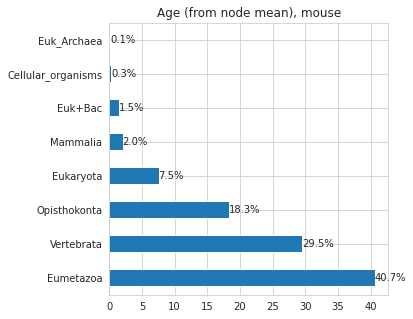

In [342]:
ax = (mouse_data['age_mean'].value_counts(normalize=True) * 100).plot.barh()

for container in ax.containers:
    ax.bar_label(container, fmt='%.1f%%')

plt.title('Age (from node mean), mouse')

In [343]:
ax = (mouse_data['age_max'].value_counts(normalize=True, dropna=False) * 100).plot.barh()

for container in ax.containers:
    ax.bar_label(container, fmt='%.1f%%')

plt.title('Age (from node mean), mouse')
plt.savefig('../data/02_plots/plot_17.png')
plt.close()

Text(0.5, 1.0, 'Age (from node mean), mouse')

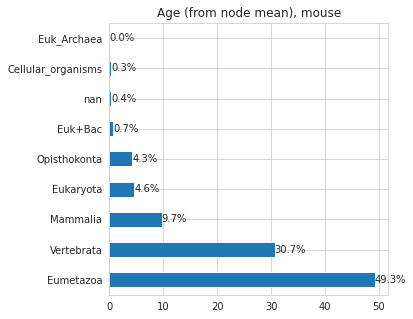

In [344]:
ax = (mouse_data['age_max'].value_counts(normalize=True, dropna=False) * 100).plot.barh()

for container in ax.containers:
    ax.bar_label(container, fmt='%.1f%%')

plt.title('Age (from node mean), mouse')

##### Длина взаимодейтсвия

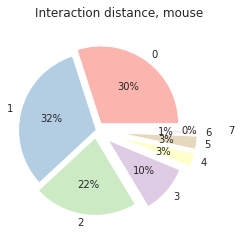

In [741]:
mouse_data['age_length'] = np.where((mouse_data['TF_age'] == 0) | (mouse_data['Tg_age'] == 0),
                                     -1,
                                     abs(mouse_data['TF_age'] - mouse_data['Tg_age']))

# no info to NAN
mouse_data['age_length'] = mouse_data['age_length'].replace({-1: np.nan})


# plot

idx = [0, 1, 2, 3, 4, 5, 6, 7]
counts = pd.Series(mouse_data['age_length'].value_counts(normalize=True) * 100)
counts.index = counts.index.astype('int64')
counts = counts[idx]

explode = (0.1, 0, 0.1, 0.2, 0.3, 0.3, 0.3, 0.6)

plt.rcParams["figure.figsize"] = 4, 4

counts.plot(kind='pie', fontsize=10, colormap="Pastel1", explode=explode,  autopct='%.0f%%')
plt.axis('equal')
plt.ylabel('')
plt.title('Interaction distance, mouse')
#plt.legend(labels=counts.index, loc="best")
plt.show()
plt.savefig('../data/02_plots/ID_02.png')
plt.close()

### Human

In [361]:
human_classes = pd.read_csv('../data/main_HUMAN.csv')
print(human_classes.shape)
human_classes = human_classes.rename(columns={"Unnamed: 0": "Protein"})
human_classes.head()

(20331, 16)


,Protein,Cellular_organisms,Euk_Archaea,Euk+Bac,Eukaryota,Opisthokonta,Eumetazoa,Vertebrata,Mammalia,modeAge,NumDBsContributing,NumDBsFiltered,entropy,NodeError,Bimodality,HGT_flag
0,A0A075B6G5,0.0,0.0,0.0,0.0,0.0,1.000000,0.0,0.000000,Eumetazoa,1,1,-0.000000,6.0,NaN,False
1,A0A075B6R3,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,1.000000,Mammalia,2,1,-0.000000,10.6666666667,16.0,False
2,A0A0A0MR89,0.0,0.0,0.0,0.0,0.0,1.000000,0.0,0.000000,Eumetazoa,1,1,-0.000000,1.0,NaN,False
3,A0A0A0MS98,0.0,0.0,0.0,0.0,0.0,0.454545,0.0,0.545455,Mammalia,11,1,0.689009,5.68181818182,1.8,False
4,A0A0A0MSJ3,0.0,0.0,0.0,1.0,0.0,0.000000,0.0,0.000000,Eukaryota,2,0,-0.000000,1.0,NaN,False


In [362]:
human_TFTG = set(list(human_data.TF) + list(human_data.Target))
len(human_TFTG)

2862

In [363]:
# for uniprot mapping - https://www.uniprot.org/uploadlists/

human_ID_UniProt = list(human_classes['Protein'])

with open('../data/age_classes/human_ID_UniProt.txt', 'w') as f:
    for el in human_ID_UniProt:
        f.write(el+' ')

 ... https://www.uniprot.org/uploadlists/ ...

In [364]:
human_prot_genes = pd.read_csv('../data/age_classes/human_UniProtMapping.txt',
                                  sep='\t',
                                  engine='python',
                                  names=['Protein', 'Gene'],
                                  header=1)
print(human_prot_genes.shape)
human_prot_genes.head()

(19629, 2)


,Protein,Gene
0,A0A075B6R3,HELZ
1,A0A0A0MR89,NRXN3
2,A0A0A0MS98,SLC4A1
3,A0A0A0MSL8,RBM14-RBM4
4,A0A0A0MTC1,RNF213


In [365]:
human_classes = human_classes.merge(human_prot_genes, how='outer', on=['Protein'])
human_classes.head()

,Protein,Cellular_organisms,Euk_Archaea,Euk+Bac,Eukaryota,Opisthokonta,Eumetazoa,Vertebrata,Mammalia,modeAge,NumDBsContributing,NumDBsFiltered,entropy,NodeError,Bimodality,HGT_flag,Gene
0,A0A075B6G5,0.0,0.0,0.0,0.0,0.0,1.000000,0.0,0.000000,Eumetazoa,1,1,-0.000000,6.0,NaN,False,NaN
1,A0A075B6R3,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,1.000000,Mammalia,2,1,-0.000000,10.6666666667,16.0,False,HELZ
2,A0A0A0MR89,0.0,0.0,0.0,0.0,0.0,1.000000,0.0,0.000000,Eumetazoa,1,1,-0.000000,1.0,NaN,False,NRXN3
3,A0A0A0MS98,0.0,0.0,0.0,0.0,0.0,0.454545,0.0,0.545455,Mammalia,11,1,0.689009,5.68181818182,1.8,False,SLC4A1
4,A0A0A0MSJ3,0.0,0.0,0.0,1.0,0.0,0.000000,0.0,0.000000,Eukaryota,2,0,-0.000000,1.0,NaN,False,NaN


In [366]:
human_classes.shape

(20479, 17)

In [367]:
human_gene_ages = human_classes.query('Gene in @human_TFTG')
#human_gene_ages = human_gene_ages[['Gene', 'modeAge']]
print(human_gene_ages.shape)
human_gene_ages

(2855, 17)


,Protein,Cellular_organisms,Euk_Archaea,Euk+Bac,Eukaryota,Opisthokonta,Eumetazoa,Vertebrata,Mammalia,modeAge,NumDBsContributing,NumDBsFiltered,entropy,NodeError,Bimodality,HGT_flag,Gene
23,A0AVK6,0.0,0.0,0.000000,0.700000,0.000000,0.000000,0.300000,0.0,Eukaryota,10,3,0.610864,4.51282051282,2.861111,False,E2F8
94,A2AB90,0.0,0.0,0.000000,0.000000,0.000000,0.000000,1.000000,0.0,Vertebrata,6,1,-0.000000,1.14285714286,4.000000,False,TAPBP
96,A2ADX3,0.0,0.0,0.000000,0.000000,0.000000,0.000000,1.000000,0.0,Vertebrata,4,1,-0.000000,0.0,NaN,False,HLA-DQB2
196,A6H8Y1,0.0,0.0,0.000000,0.666667,0.000000,0.333333,0.000000,0.0,Eukaryota,9,4,0.636514,6.35897435897,0.357143,False,BDP1
501,A6NNB3,0.0,0.0,0.000000,0.000000,0.000000,0.083333,0.916667,0.0,Vertebrata,12,1,0.286836,0.74358974359,0.091270,False,IFITM5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20459,Q9Y6W6,0.0,0.0,0.142857,0.714286,0.000000,0.142857,0.000000,0.0,Eukaryota,7,6,0.796312,3.58974358974,0.992063,False,DUSP10
20461,Q9Y6X0,0.0,0.0,0.000000,0.166667,0.000000,0.000000,0.833333,0.0,Vertebrata,12,1,0.450561,3.23076923077,0.738095,False,SETBP1
20463,Q9Y6X2,0.0,0.0,0.000000,0.583333,0.083333,0.000000,0.333333,0.0,Eukaryota,12,1,0.887694,4.64102564103,3.511905,False,PIAS3
20468,Q9Y6X8,0.0,0.0,0.000000,0.000000,0.000000,0.636364,0.363636,0.0,Eumetazoa,11,2,0.655482,1.07692307692,2.000000,False,ZHX2


#### Add New info to Graf:

In [368]:
human_attrs = human_gene_ages[['Gene', 'modeAge']].set_index('Gene').T.to_dict('dict')
nx.set_node_attributes(human_graph, human_attrs) 

/tmp/ipykernel_112930/3792171582.py:1: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  human_attrs = human_gene_ages[['Gene', 'modeAge']].set_index('Gene').T.to_dict('dict')


In [369]:
human_gene_ages.groupby('modeAge').count().Gene

modeAge
Cellular_organisms    145
Euk+Bac               230
Euk_Archaea            27
Eukaryota             650
Eumetazoa             891
Mammalia              212
Opisthokonta          167
Vertebrata            533
Name: Gene, dtype: int64

In [370]:
selected_nodes_human = [n for n,v in human_graph.nodes(data=True) if v]
selected_edges_human = [(u, v) for u, v, e in human_graph.edges(data=True) if u in selected_nodes_human or v in selected_nodes_human]

human_H = nx.DiGraph(((u, v, e) for u,v,e in human_graph.edges(data=True) if u in selected_nodes_human or v in selected_nodes_human))
nx.set_node_attributes(human_H, human_attrs)


In [371]:
color_map_h = []

color_dict_h = {'Vertebrata': 'tab:blue', 'Cellular_organisms': 'tab:green',
                'Eumetazoa': 'gold', 'Euk+Bac': 'tab:red',
                'Euk_Archaea': 'tab:pink', 'Eukaryota': 'tab:olive',
                'Opisthokonta': 'tab:cyan', 'Mammalia': 'red'}

for node in human_H.nodes(data=True):
    
    if node[1].get('modeAge') in color_dict.keys():
        color_map_h.append(color_dict_h[node[1].get('modeAge')])
    
    else: 
        color_map_h.append('ivory')

In [372]:
plt.figure(figsize=(50, 50))
pos = nx.bipartite_layout(human_H, selected_nodes_human)
nx.draw_networkx_nodes(human_H, pos, node_color=color_map_h)
nx.draw_networkx_edges(human_H, pos)

#plt.show()
plt.savefig('../data/02_plots/plot_07.png')
plt.close()

In [373]:
plt.figure(figsize=(50, 50))
pos = nx.circular_layout(human_H)

nx.draw_networkx_nodes(human_H, pos, node_color=color_map_h)
nx.draw_networkx_edges(human_H, pos)

#plt.show()
plt.savefig('../data/02_plots/plot_08.png')
plt.close()

Связь-возраст

In [374]:
htf_ages_list = []
htg_ages_list = []

for i in human_data.TF:
    if list(human_gene_ages.loc[human_gene_ages['Gene'] == i]['modeAge']):
        htf_ages_list.append(human_gene_ages.loc[human_gene_ages['Gene'] == i]['modeAge'].iloc[0])
        
    else:
        htf_ages_list.append(None)

for i in human_data.Target:
    if list(human_gene_ages.loc[human_gene_ages['Gene'] == i]['modeAge']):
        htg_ages_list.append(human_gene_ages.loc[human_gene_ages['Gene'] == i]['modeAge'].iloc[0])
    else:
        htg_ages_list.append(None)

In [375]:
human_data['TF_age'] = htf_ages_list
human_data['Tg_age'] = htg_ages_list

human_data['TF_age'].replace('None', np.nan, inplace=True)
human_data['Tg_age'].replace('None', np.nan, inplace=True)


In [376]:
# сохраним датафрейм
human_data.to_csv('../data/trrust_rawdata.human_classes.csv')

In [377]:
# Есть ребра, где классы не совпадают
human_data[human_data['TF_age'] != human_data['Tg_age']]

,TF,Target,Mode,PMID,TF_age,Tg_age
0,AATF,BAX,Repression,22909821,Eukaryota,Eumetazoa
1,AATF,CDKN1A,Unknown,17157788,Eukaryota,Eumetazoa
2,AATF,KLK3,Unknown,23146908,Eukaryota,Mammalia
3,AATF,MYC,Activation,20549547,Eukaryota,Eumetazoa
4,AATF,TP53,Unknown,17157788,Eukaryota,Opisthokonta
...,...,...,...,...,...,...
9390,ZNF444,SCARF1,Activation,11978792,Mammalia,Vertebrata
9391,ZNF76,CDKN1A,Repression,15280358,Eukaryota,Eumetazoa
9393,ZNF76,TALDO1,Unknown,14702349,Eukaryota,Cellular_organisms
9394,ZNRD1,ABCB1,Activation,16373708,None,Euk+Bac


In [378]:
human_data['TF_age'].fillna('', inplace=True)
human_data['Tg_age'].fillna('', inplace=True)

human_data["age"] = human_data.apply(lambda row: row["TF_age"] if row["Tg_age"] == row["TF_age"] else row["TF_age"] + row["Tg_age"], axis=1) 

In [379]:
human_data['age'].replace('', np.nan, inplace=True)
human_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9396 entries, 0 to 9395
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   TF      9396 non-null   object
 1   Target  9396 non-null   object
 2   Mode    9396 non-null   object
 3   PMID    9396 non-null   object
 4   TF_age  9396 non-null   object
 5   Tg_age  9396 non-null   object
 6   age     9395 non-null   object
dtypes: object(7)
memory usage: 514.0+ KB


In [380]:
human_data.groupby('age', as_index=False).count()

,age,TF,Target,Mode,PMID,TF_age,Tg_age
0,Cellular_organisms,19,19,19,19,19,19
1,Cellular_organismsEuk+Bac,18,18,18,18,18,18
2,Cellular_organismsEuk_Archaea,4,4,4,4,4,4
3,Cellular_organismsEukaryota,34,34,34,34,34,34
4,Cellular_organismsEumetazoa,81,81,81,81,81,81
5,Cellular_organismsMammalia,19,19,19,19,19,19
6,Cellular_organismsOpisthokonta,36,36,36,36,36,36
7,Cellular_organismsVertebrata,50,50,50,50,50,50
8,Euk+Bac,3,3,3,3,3,3
9,Euk+BacCellular_organisms,2,2,2,2,2,2


In [381]:
human_data[['age']].value_counts()

age                           
Eumetazoa                         1539
EumetazoaVertebrata               1010
EumetazoaEukaryota                 741
OpisthokontaEumetazoa              540
VertebrataEumetazoa                437
Vertebrata                         410
OpisthokontaVertebrata             385
EukaryotaEumetazoa                 355
EumetazoaEuk+Bac                   340
EumetazoaMammalia                  323
OpisthokontaEukaryota              309
EumetazoaOpisthokonta              271
Eukaryota                          261
VertebrataEukaryota                259
EumetazoaCellular_organisms        240
EukaryotaVertebrata                193
OpisthokontaEuk+Bac                171
Opisthokonta                       161
VertebrataMammalia                 146
OpisthokontaMammalia               138
EukaryotaOpisthokonta              103
OpisthokontaCellular_organisms     101
VertebrataOpisthokonta             101
VertebrataEuk+Bac                   98
Cellular_organismsEumetazoa      

In [382]:
# Доля классов с учетом всех связей
human_data[['age']].value_counts(normalize=True, dropna=False)

age                           
Eumetazoa                         0.163793
EumetazoaVertebrata               0.107493
EumetazoaEukaryota                0.078863
OpisthokontaEumetazoa             0.057471
VertebrataEumetazoa               0.046509
Vertebrata                        0.043636
OpisthokontaVertebrata            0.040975
EukaryotaEumetazoa                0.037782
EumetazoaEuk+Bac                  0.036186
EumetazoaMammalia                 0.034376
OpisthokontaEukaryota             0.032886
EumetazoaOpisthokonta             0.028842
Eukaryota                         0.027778
VertebrataEukaryota               0.027565
EumetazoaCellular_organisms       0.025543
EukaryotaVertebrata               0.020541
OpisthokontaEuk+Bac               0.018199
Opisthokonta                      0.017135
VertebrataMammalia                0.015539
OpisthokontaMammalia              0.014687
EukaryotaOpisthokonta             0.010962
VertebrataOpisthokonta            0.010749
OpisthokontaCellular_or

In [383]:
# Доля классов среди исзвестных классов
human_data[['age']].value_counts(normalize=True)

age                           
Eumetazoa                         0.163811
EumetazoaVertebrata               0.107504
EumetazoaEukaryota                0.078872
OpisthokontaEumetazoa             0.057477
VertebrataEumetazoa               0.046514
Vertebrata                        0.043640
OpisthokontaVertebrata            0.040979
EukaryotaEumetazoa                0.037786
EumetazoaEuk+Bac                  0.036189
EumetazoaMammalia                 0.034380
OpisthokontaEukaryota             0.032890
EumetazoaOpisthokonta             0.028845
Eukaryota                         0.027781
VertebrataEukaryota               0.027568
EumetazoaCellular_organisms       0.025546
EukaryotaVertebrata               0.020543
OpisthokontaEuk+Bac               0.018201
Opisthokonta                      0.017137
VertebrataMammalia                0.015540
OpisthokontaMammalia              0.014689
EukaryotaOpisthokonta             0.010963
OpisthokontaCellular_organisms    0.010750
VertebrataOpisthokonta 

In [384]:
plt.figure(figsize=(15, 15))
ax = (human_data[['age']].value_counts(normalize=True) * 100).plot.barh()

for container in ax.containers:
    ax.bar_label(container, fmt='%.1f%%')

plt.savefig('../data/02_plots/plot_09.png')
plt.close()

###  heatmap

In [385]:
# heatmap

# Substituting nans with "no info"
human_data[['Tg_age', 'TF_age']] = human_data[['Tg_age', 'TF_age']].replace('', 'no info')

In [386]:
heatmap_h = pd.crosstab(human_data.TF_age, human_data.Tg_age)
heatmap_h

Tg_age,Cellular_organisms,Euk+Bac,Euk_Archaea,Eukaryota,Eumetazoa,Mammalia,Opisthokonta,Vertebrata,no info
TF_age,,,,,,,,,
Cellular_organisms,18,18,4,34,81,19,36,50,1
Euk+Bac,2,1,0,4,11,3,3,3,0
Euk_Archaea,0,0,0,6,4,1,3,6,0
Eukaryota,46,71,29,237,355,64,103,193,9
Eumetazoa,240,340,22,741,1476,323,271,1010,49
Mammalia,3,5,0,14,60,12,10,35,2
Opisthokonta,101,171,8,309,540,138,135,385,20
Vertebrata,59,98,11,259,437,146,101,375,22
no info,0,2,0,15,14,2,6,13,1


Text(0.5, 1.0, 'Age classes heatmap, human')

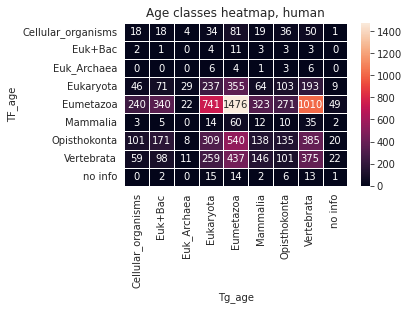

In [387]:
plt.rcParams["figure.figsize"] = 5, 3

sns.heatmap(heatmap_h, annot=True, linewidths=0.5, fmt='g')
plt.title('Age classes heatmap, human')

In [388]:
sns.heatmap(heatmap_h, annot=True, linewidths=0.5, fmt='g')
plt.title('Age classes heatmap, human')
plt.savefig('../data/02_plots/human_heatmap_01.png')
plt.close()

### установка возраста по наиболее молодому узлу

In [389]:
# установление возраста связи по самому молодому узлу
classes = ['no info', 'Cellular_organisms', 'Euk_Archaea','Euk+Bac', 'Eukaryota',
           'Opisthokonta', 'Eumetazoa', 'Vertebrata', 'Mammalia']

human_data['Tg_age'] = human_data['Tg_age'].apply(lambda x: classes.index(x))
human_data['TF_age'] = human_data['TF_age'].apply(lambda x: classes.index(x))

In [390]:
human_data['age_max'] = np.where(human_data['TF_age'] > human_data['Tg_age'], 
                                 human_data['TF_age'],
                                 human_data['Tg_age'])

In [391]:
# перевод обратно в названия классов
human_data['age_max'] = human_data['age_max'].apply(lambda x: classes[x])

In [392]:
# no info to NAN
human_data['age_max'] = human_data['age_max'].replace({'no info': np.nan})

In [393]:
# Доля классов (по молодому) с учетом всех связей
human_data[['age_max']].value_counts(normalize=True, dropna=False)

age_max           
Eumetazoa             0.441039
Vertebrata            0.321626
Opisthokonta          0.095253
Mammalia              0.089080
Eukaryota             0.047999
Euk+Bac               0.002448
Cellular_organisms    0.002022
Euk_Archaea           0.000426
NaN                   0.000106
dtype: float64

In [394]:
# Доля классов среди известных классов (по молодому)
human_data[['age_max']].value_counts(normalize=True)

age_max           
Eumetazoa             0.441086
Vertebrata            0.321660
Opisthokonta          0.095263
Mammalia              0.089090
Eukaryota             0.048004
Euk+Bac               0.002448
Cellular_organisms    0.002022
Euk_Archaea           0.000426
dtype: float64

Text(0.5, 1.0, 'Age (from most recent node), human')

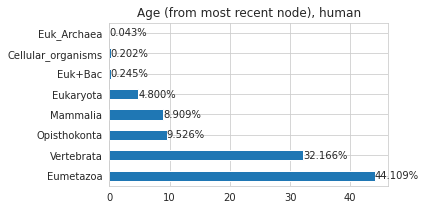

In [395]:
ax = (human_data['age_max'].value_counts(normalize=True) * 100).plot.barh()

for container in ax.containers:
    ax.bar_label(container, fmt='%.3f%%')

plt.title('Age (from most recent node), human')
#plt.savefig('../data/02_plots/plot_18.png')
#plt.close()

In [396]:
ax = (human_data['age_max'].value_counts(normalize=True) * 100).plot.barh()

for container in ax.containers:
    ax.bar_label(container, fmt='%.3f%%')

plt.title('Age (from most recent node), human')
plt.savefig('../data/02_plots/plot_18.png')
plt.close()

Text(0.5, 1.0, 'Age (from most recent node), human')

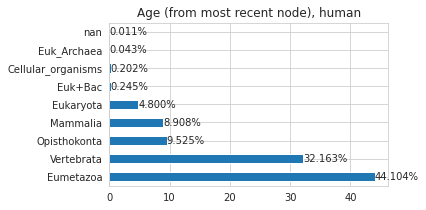

In [397]:
ax = (human_data['age_max'].value_counts(normalize=True, dropna=False) * 100).plot.barh()

for container in ax.containers:
    ax.bar_label(container, fmt='%.3f%%')

plt.title('Age (from most recent node), human')

In [398]:
ax = (human_data['age_max'].value_counts(normalize=True, dropna=False) * 100).plot.barh()

for container in ax.containers:
    ax.bar_label(container, fmt='%.3f%%')

plt.title('Age (from most recent node), human')
plt.savefig('../data/02_plots/plot_19.png')
plt.close()

### установление возраста связи по среднему возрасту между узлами
если один из участников неизвестен - присваиваем ребру возраст известного

In [399]:
# + 0.1 use for math round

human_data['age_mean'] = np.where((human_data['TF_age'] == 0) | (human_data['Tg_age'] == 0),
                                  human_data[['TF_age', 'Tg_age']].max(axis=1),
                                  (human_data['TF_age'] + human_data['Tg_age'] + 0.1) / 2)

In [400]:
# float to int
human_data['age_mean'] = human_data['age_mean'].round().astype('int64')

In [401]:
# перевод обратно в названия классов
human_data['age_mean'] = human_data['age_mean'].apply(lambda x: classes[x])

# no info to NAN
human_data['age_mean'] = human_data['age_mean'].replace({'no info': np.nan})

In [402]:
# Доля классов (по среднему) с учетом всех связей
human_data[['age_mean']].value_counts(normalize=True, dropna=False)

age_mean          
Eumetazoa             0.359089
Vertebrata            0.254151
Opisthokonta          0.229991
Eukaryota             0.103980
Euk+Bac               0.027139
Mammalia              0.020966
Euk_Archaea           0.002554
Cellular_organisms    0.002022
NaN                   0.000106
dtype: float64

In [403]:
# Доля классов среди известных классов (по молодому)
human_data[['age_mean']].value_counts(normalize=True)

age_mean          
Eumetazoa             0.359127
Vertebrata            0.254178
Opisthokonta          0.230016
Eukaryota             0.103991
Euk+Bac               0.027142
Mammalia              0.020969
Euk_Archaea           0.002555
Cellular_organisms    0.002022
dtype: float64

Text(0.5, 1.0, 'Age (from node mean), human')

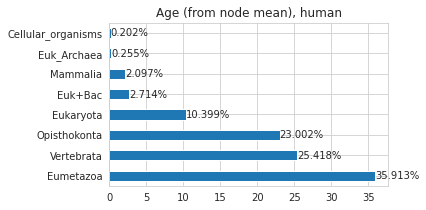

In [404]:
ax = (human_data['age_mean'].value_counts(normalize=True) * 100).plot.barh()

for container in ax.containers:
    ax.bar_label(container, fmt='%.3f%%')

plt.title('Age (from node mean), human')

In [405]:
ax = (human_data['age_mean'].value_counts(normalize=True) * 100).plot.barh()

for container in ax.containers:
    ax.bar_label(container, fmt='%.1f%%')

plt.title('Age (from node mean), human')
plt.savefig('../data/02_plots/plot_20.png')
plt.close()

Text(0.5, 1.0, 'Age (from node mean), human')

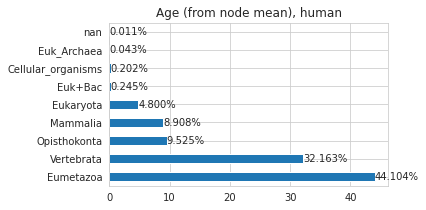

In [406]:
ax = (human_data['age_max'].value_counts(normalize=True, dropna=False) * 100).plot.barh()

for container in ax.containers:
    ax.bar_label(container, fmt='%.3f%%')

plt.title('Age (from node mean), human')

In [407]:
ax = (human_data['age_max'].value_counts(normalize=True, dropna=False) * 100).plot.barh()

for container in ax.containers:
    ax.bar_label(container, fmt='%.1f%%')

plt.title('Age (from node mean), human')
plt.savefig('../data/02_plots/plot_21.png')
plt.close()

#### Длина связи

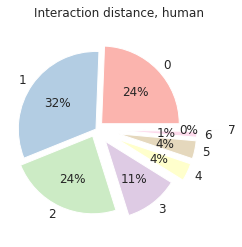

In [744]:
human_data['age_length'] = np.where((human_data['TF_age'] == 0) | (human_data['Tg_age'] == 0),
                                     -1,
                                     abs(human_data['TF_age'] - human_data['Tg_age']))

# no info to NAN
human_data['age_length'] = human_data['age_length'].replace({-1: np.nan})


# plot

idx = [0, 1, 2, 3, 4, 5, 6, 7]
counts = pd.Series(human_data['age_length'].value_counts(normalize=True) * 100)
counts.index = counts.index.astype('int64')
counts = counts[idx]

explode = (0.1, 0, 0.1, 0.2, 0.3, 0.3, 0.3, 0.6)

counts.plot(kind='pie', fontsize=12, colormap="Pastel1", explode=explode,  autopct='%.0f%%')
plt.axis('equal')
plt.ylabel('')
plt.title('Interaction distance, human')
#plt.legend(labels=counts.index, loc="best")
plt.show()
plt.savefig('../data/02_plots/ID_03.png')
plt.close()

# Degree connectivity and clustering

In [443]:
yeast_graph = nx.from_pandas_edgelist(yeast_data, 'Tf', 'Tg', ['age_max'], create_using=nx.DiGraph())
mouse_graph = nx.from_pandas_edgelist(mouse_data, 'TF', 'Target', ['Mode', 'age_max'], create_using=nx.DiGraph())
human_graph = nx.from_pandas_edgelist(human_data, 'TF', 'Target', ['Mode', 'age_max'], create_using=nx.DiGraph())

In [444]:
yeast_attrs = yeast_gene_ages[['Gene', 'modeAge']].set_index('Gene').T.to_dict('dict')
nx.set_node_attributes(yeast_graph, yeast_attrs) 

mouse_attrs = mouse_gene_ages[['Gene', 'modeAge']].set_index('Gene').T.to_dict('dict')
nx.set_node_attributes(mouse_graph, mouse_attrs) 

human_attrs = human_gene_ages[['Gene', 'modeAge']].set_index('Gene').T.to_dict('dict')
nx.set_node_attributes(human_graph, human_attrs) 

/tmp/ipykernel_112930/4125219519.py:4: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  mouse_attrs = mouse_gene_ages[['Gene', 'modeAge']].set_index('Gene').T.to_dict('dict')
/tmp/ipykernel_112930/4125219519.py:7: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  human_attrs = human_gene_ages[['Gene', 'modeAge']].set_index('Gene').T.to_dict('dict')


## коррелирует ли node degree с age class

#### Yeasts

In [494]:
yeast_gene_ages_dropped = yeast_gene_ages[['Gene', 'modeAge']]

yeast_ndegree = pd.DataFrame.from_dict(dict(yeast_graph.degree()), orient='index').reset_index(level=0)
yeast_ndegree.columns = ['Gene', 'Node_Degree']

yeast_ndegree = yeast_ndegree.merge(yeast_gene_ages_dropped, how='outer', on=['Gene'])

yeast_ndegree.head()

,Gene,Node_Degree,modeAge
0,YAL051W,61,Saccharomyceta
1,YAL016W,4,Eukaryota
2,YAL034WA,3,NaN
3,YAL035CA,1,NaN
4,YAL035W,4,Euk_Archaea


In [495]:
classes = ['no info', 'Cellular_organisms', 'Euk_Archaea','Euk+Bac', 'Eukaryota',
           'Opisthokonta', 'Dikarya', 'Ascomycota', 'Saccharomyceta']

yeast_ndegree['modeAge'].fillna('no info', inplace=True)
yeast_ndegree['Age'] = yeast_ndegree['modeAge'].apply(lambda x: classes.index(x))

Text(0.5, 1.0, 'Node Degree in age classes, yeast')

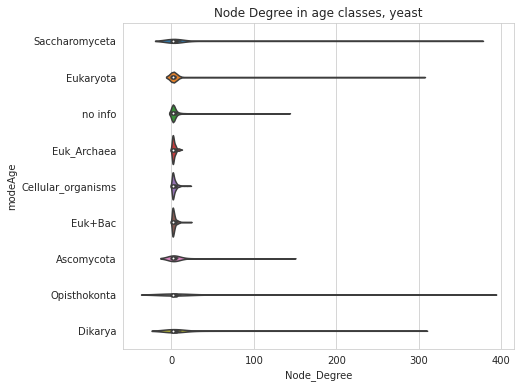

In [499]:
sns.violinplot(y="modeAge", x="Node_Degree", data=yeast_ndegree)
plt.title('Node Degree in age classes, yeast')

Text(0.5, 1.0, 'Node Degree in age classes, yeast')

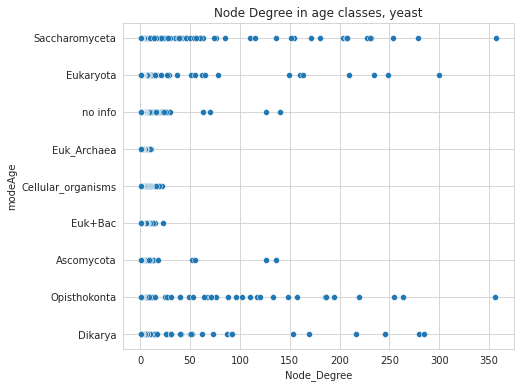

In [500]:
sns.scatterplot(y="modeAge", x="Node_Degree", data=yeast_ndegree)
plt.title('Node Degree in age classes, yeast')

<AxesSubplot:>

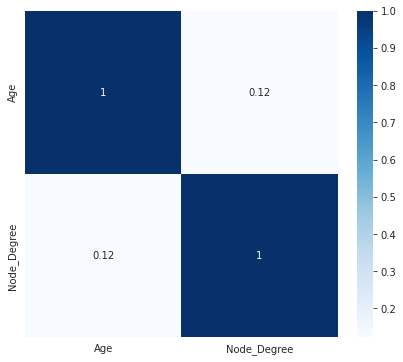

In [501]:
corr = yeast_ndegree[['Age', 'Node_Degree']].corr()

# plot the heatmap
sns.heatmap(corr, cmap="Blues", annot=True)

#### Mouse

In [488]:
mouse_gene_ages_dropped = mouse_gene_ages[['Gene', 'modeAge']]

mouse_ndegree = pd.DataFrame.from_dict(dict(mouse_graph.degree()), orient='index').reset_index(level=0)
mouse_ndegree.columns = ['Gene', 'Node_Degree']

mouse_ndegree = mouse_ndegree.merge(mouse_gene_ages_dropped, how='outer', on=['Gene'])

mouse_ndegree.head()

,Gene,Node_Degree,modeAge
0,Aatf,6,Eukaryota
1,Bak1,3,Eumetazoa
2,Bax,13,Eumetazoa
3,Bbc3,5,Mammalia
4,Cdkn1a,65,Eumetazoa


In [489]:
classes = ['no info', 'Cellular_organisms', 'Euk_Archaea','Euk+Bac', 'Eukaryota',
           'Opisthokonta', 'Eumetazoa', 'Vertebrata', 'Mammalia']

mouse_ndegree['modeAge'].fillna('no info', inplace=True)
mouse_ndegree['Age'] = mouse_ndegree['modeAge'].apply(lambda x: classes.index(x))

Text(0.5, 1.0, 'Node Degree in age classes, Mouse')

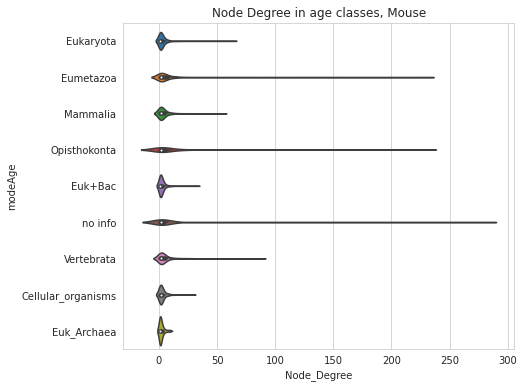

In [491]:
sns.violinplot(y="modeAge", x="Node_Degree", data=mouse_ndegree)
plt.title('Node Degree in age classes, Mouse')

Text(0.5, 1.0, 'Node Degree in age classes, Mouse')

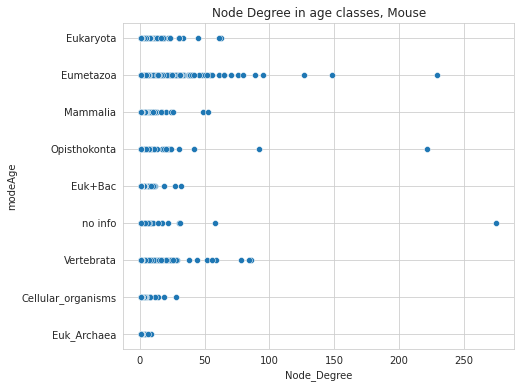

In [498]:
sns.scatterplot(y="modeAge", x="Node_Degree", data=mouse_ndegree)
plt.title('Node Degree in age classes, Mouse')

<AxesSubplot:>

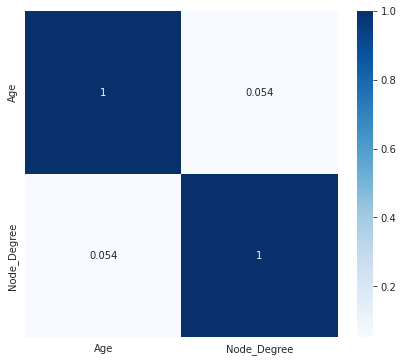

In [493]:
corr = mouse_ndegree[['Age', 'Node_Degree']].corr()

# plot the heatmap
sns.heatmap(corr, cmap="Blues", annot=True)

#### Human

In [448]:
human_gene_ages_dropped = human_gene_ages[['Gene', 'modeAge']]

human_ndegree = pd.DataFrame.from_dict(dict(human_graph.degree()), orient='index').reset_index(level=0)
human_ndegree.columns = ['Gene', 'Node_Degree']

human_ndegree = human_ndegree.merge(human_gene_ages_dropped, how='outer', on=['Gene'])

human_ndegree.head()

,Gene,Node_Degree,modeAge
0,AATF,5,Eukaryota
1,BAX,26,Eumetazoa
2,CDKN1A,115,Eumetazoa
3,KLK3,25,Mammalia
4,MYC,174,Eumetazoa


In [475]:
classes = ['no info', 'Cellular_organisms', 'Euk_Archaea','Euk+Bac', 'Eukaryota',
           'Opisthokonta', 'Eumetazoa', 'Vertebrata', 'Mammalia']

human_ndegree['modeAge'].fillna('no info', inplace=True)
human_ndegree['Age'] = human_ndegree['modeAge'].apply(lambda x: classes.index(x))

Text(0.5, 1.0, 'Node Degree in age classes, Human')

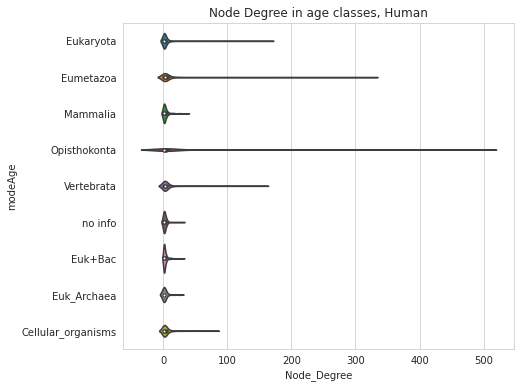

In [476]:
sns.violinplot(y="modeAge", x="Node_Degree", data=human_ndegree)
plt.title('Node Degree in age classes, Human')

Text(0.5, 1.0, 'Node Degree in age classes, Human')

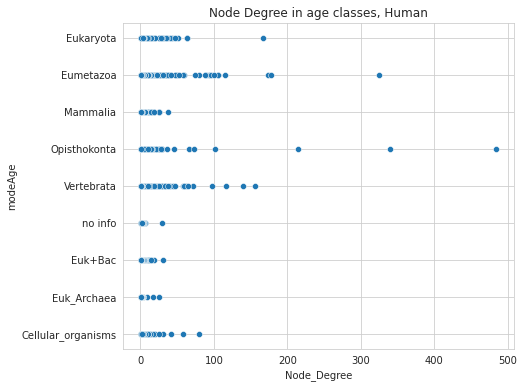

In [486]:
sns.scatterplot(y="modeAge", x="Node_Degree", data=human_ndegree)
plt.title('Node Degree in age classes, Human')

<AxesSubplot:>

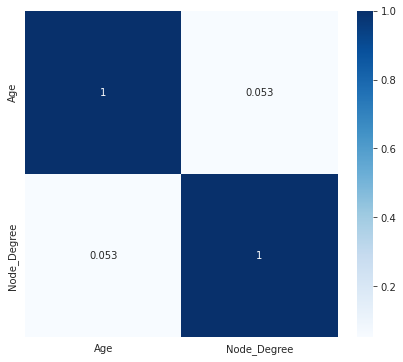

In [487]:
corr = human_ndegree[['Age', 'Node_Degree']].corr()

# plot the heatmap
sns.heatmap(corr, cmap="Blues", annot=True)

### Сonnectivity

#### yeasts

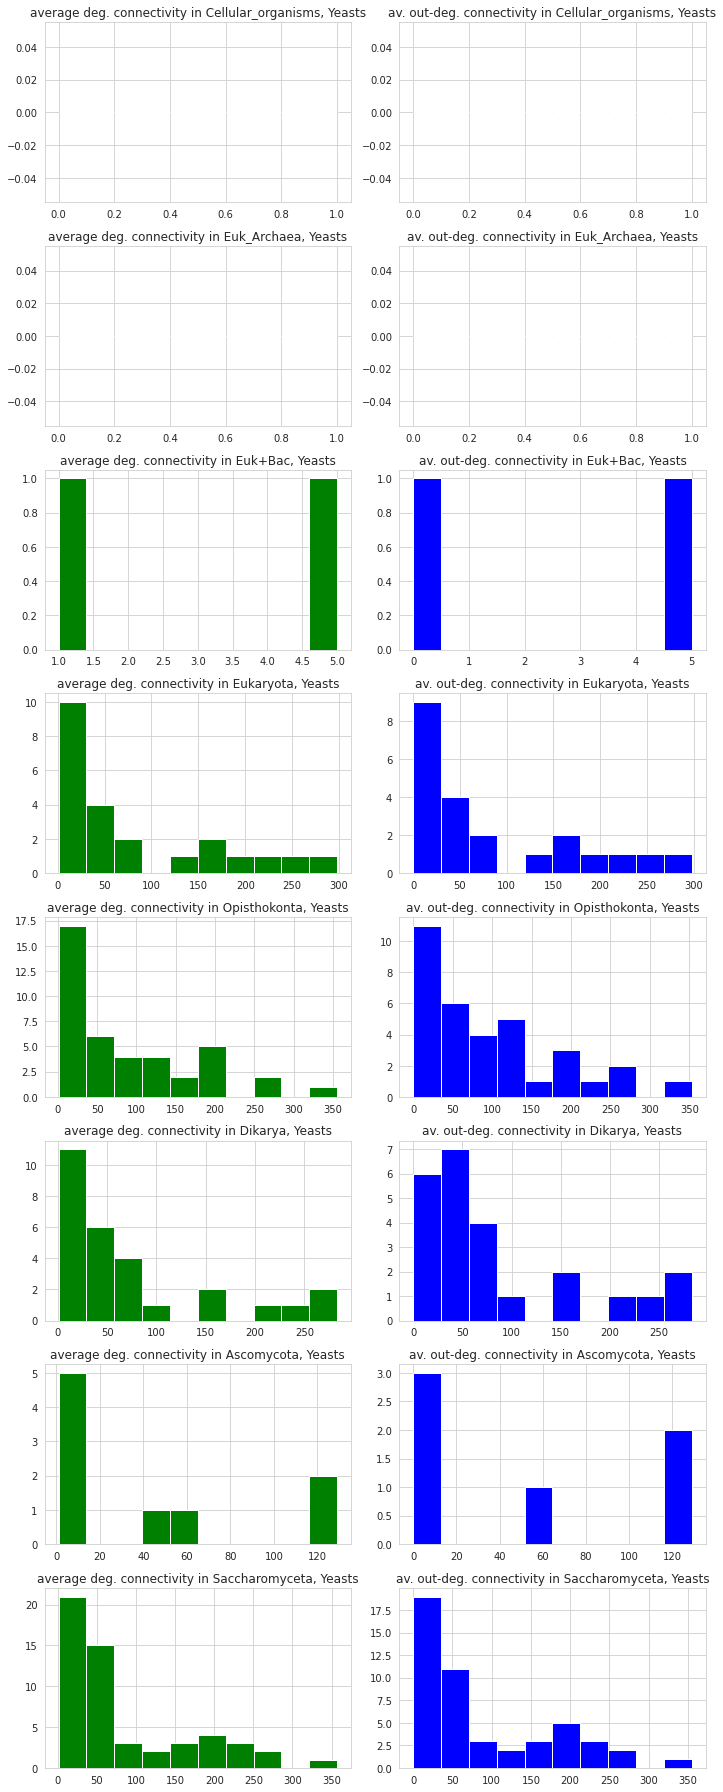

In [572]:
classes = ['no info', 'Cellular_organisms', 'Euk_Archaea','Euk+Bac', 'Eukaryota',
           'Opisthokonta', 'Dikarya', 'Ascomycota', 'Saccharomyceta']

plt.rcParams["figure.figsize"] = 10, 25

fig, axes = plt.subplots(8, 2)

for i, class_ in enumerate(classes[1:]):
    temp_data = yeast_data[yeast_data['TF_age'] == i + 1]
    
    temp_graph = nx.from_pandas_edgelist(temp_data, 
                                         'Tf', 'Tg', 
                                         ['age_max'],
                                         create_using=nx.DiGraph())

    #  is the average nearest neighbor degree of nodes with degree k
    temp_av_conn = nx.average_degree_connectivity(temp_graph)
    temp_out_conn = nx.average_degree_connectivity(temp_graph, source='out')

    axes[i, 0].hist(temp_av_conn, color='g')
    axes[i, 0].set_title(f'average deg. connectivity in {class_}, Yeasts')
    
    axes[i, 1].hist(temp_out_conn, color='b')
    axes[i, 1].set_title(f'av. out-deg. connectivity in {class_}, Yeasts')
    
plt.tight_layout() 
plt.show()

#### mouse

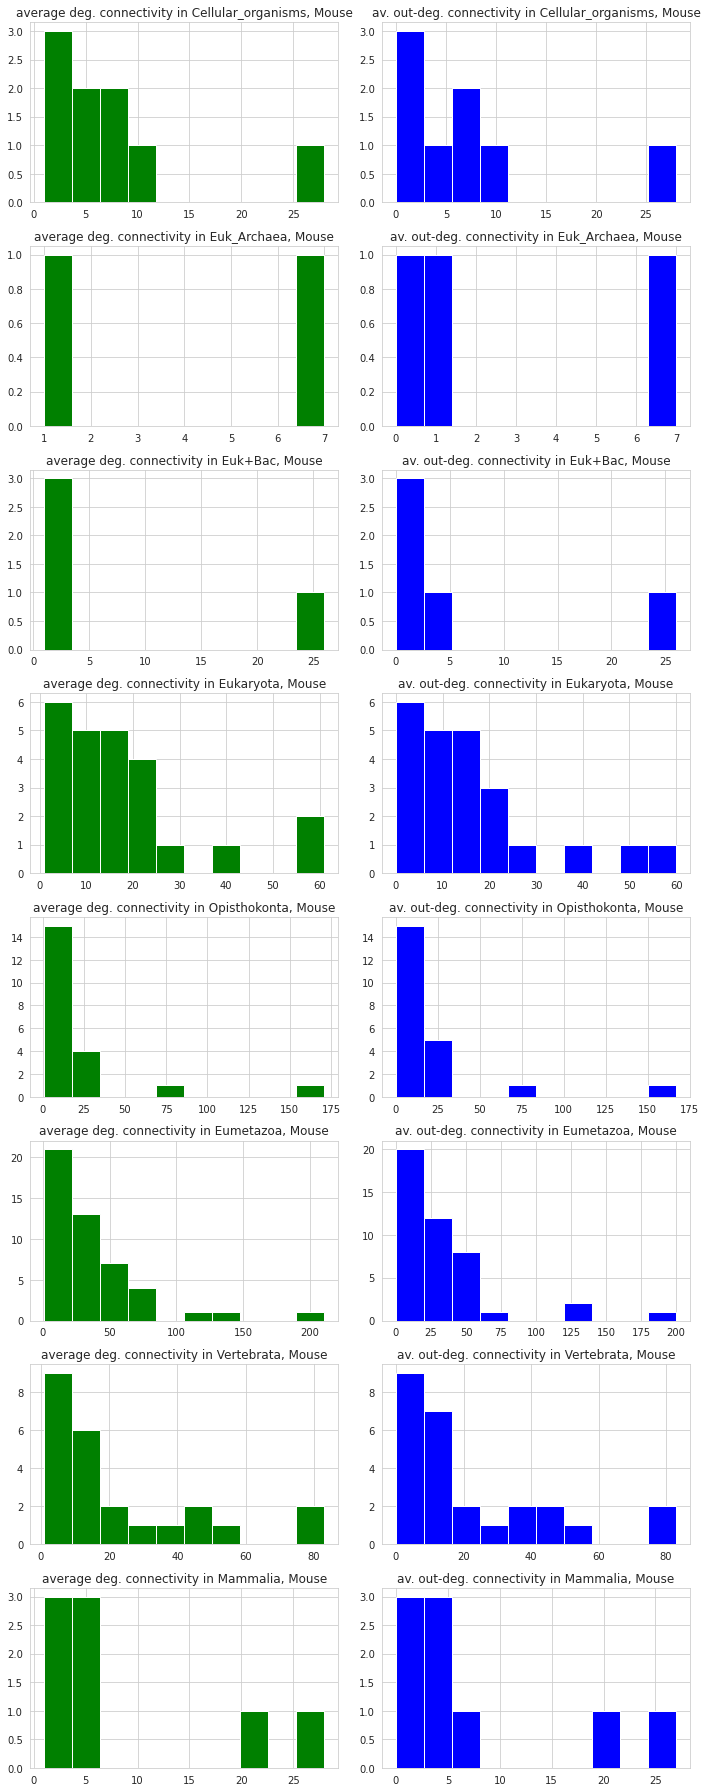

In [571]:
classes = ['no info', 'Cellular_organisms', 'Euk_Archaea','Euk+Bac', 'Eukaryota',
           'Opisthokonta', 'Eumetazoa', 'Vertebrata', 'Mammalia']

fig, axes = plt.subplots(8, 2)

for i, class_ in enumerate(classes[1:]):
    temp_data = mouse_data[mouse_data['TF_age'] == i + 1]
    
    temp_graph = nx.from_pandas_edgelist(temp_data, 
                                         'TF', 'Target', 
                                         ['Mode', 'age_max'],
                                         create_using=nx.DiGraph())

    #  is the average nearest neighbor degree of nodes with degree k
    temp_av_conn = nx.average_degree_connectivity(temp_graph)
    temp_out_conn = nx.average_degree_connectivity(temp_graph, source='out')

    axes[i, 0].hist(temp_av_conn, color='g')
    axes[i, 0].set_title(f'average deg. connectivity in {class_}, Mouse')
    
    axes[i, 1].hist(temp_out_conn, color='b')
    axes[i, 1].set_title(f'av. out-deg. connectivity in {class_}, Mouse')
    
plt.tight_layout() 
plt.show()

#### human

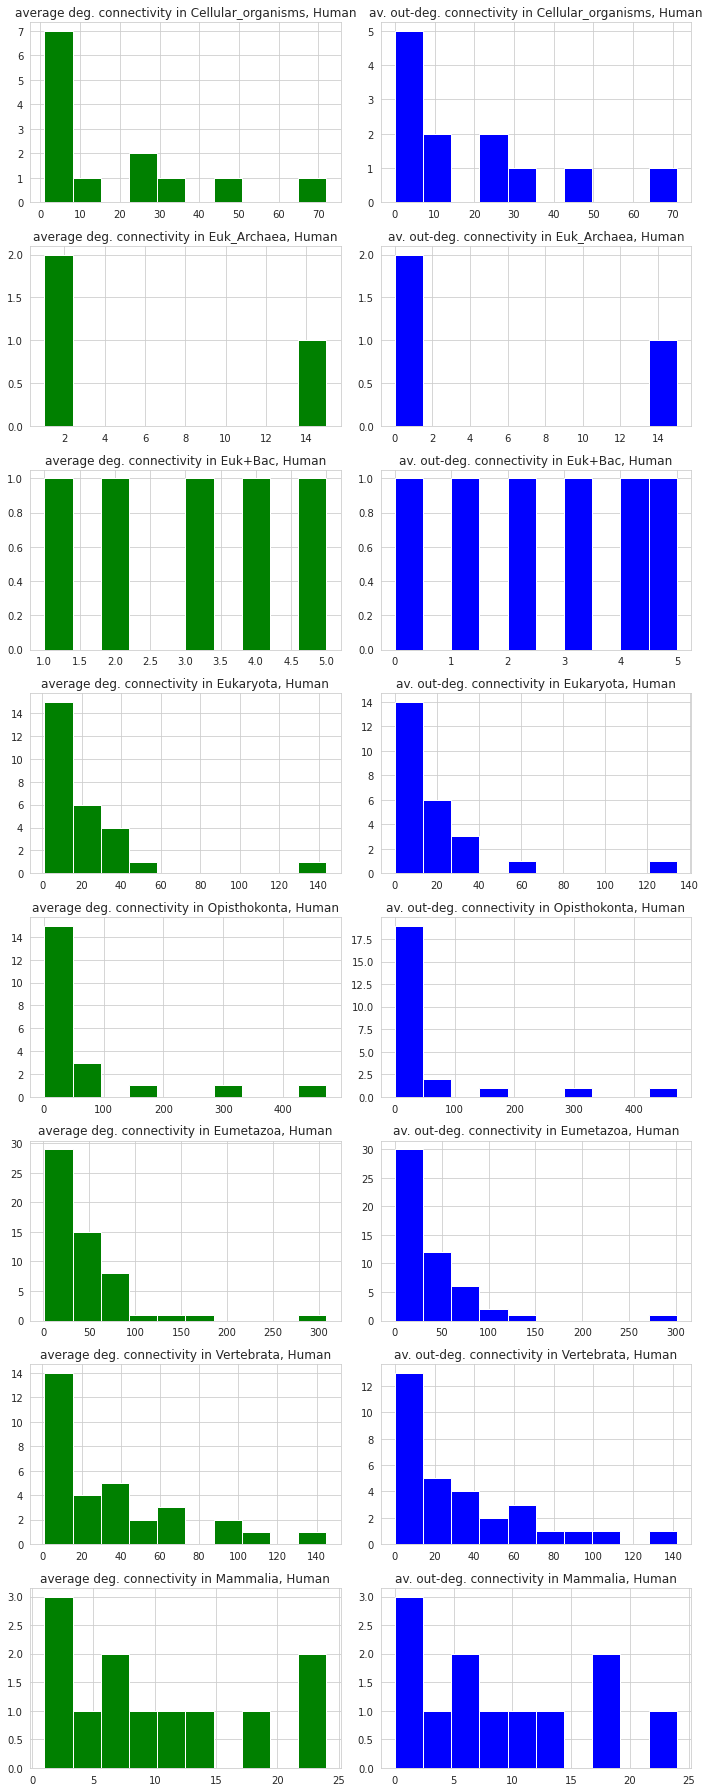

In [570]:
classes = ['no info', 'Cellular_organisms', 'Euk_Archaea','Euk+Bac', 'Eukaryota',
           'Opisthokonta', 'Eumetazoa', 'Vertebrata', 'Mammalia']

fig, axes = plt.subplots(8, 2)

for i, class_ in enumerate(classes[1:]):
    temp_data = human_data[human_data['TF_age'] == i + 1]
    
    temp_graph = nx.from_pandas_edgelist(temp_data, 
                                         'TF', 'Target', 
                                         ['Mode', 'age_max'],
                                         create_using=nx.DiGraph())

    #  is the average nearest neighbor degree of nodes with degree k
    temp_av_conn = nx.average_degree_connectivity(temp_graph)
    temp_out_conn = nx.average_degree_connectivity(temp_graph, source='out')

    axes[i, 0].hist(temp_av_conn, color='g')
    axes[i, 0].set_title(f'average deg. connectivity in {class_}, Human')
    
    axes[i, 1].hist(temp_out_conn, color='b')
    axes[i, 1].set_title(f'av. out-deg. connectivity in {class_}, Human')
    
plt.tight_layout() 
plt.show()

### Clustering

In [609]:
clustering_table = pd.DataFrame(columns=['organism','class', 'type', 'clust_coefficient'])

#### yeasts

In [610]:
# по возрасту ТФ

classes = ['no info', 'Cellular_organisms', 'Euk_Archaea','Euk+Bac', 'Eukaryota',
           'Opisthokonta', 'Dikarya', 'Ascomycota', 'Saccharomyceta']

for i, class_ in enumerate(classes[1:]):
    temp_data = yeast_data[yeast_data['TF_age'] == i + 1]
    
    if temp_data.empty:
        continue
    
    temp_graph = nx.from_pandas_edgelist(temp_data, 
                                         'Tf', 'Tg', 
                                         ['age_max'],
                                         create_using=nx.DiGraph())
    
    clustering_table.loc[len(clustering_table)] = ['yeasts', class_, 'TF', nx.average_clustering(temp_graph)]
    
    print(f'Кластеризация: \t\t{round(nx.transitivity(temp_graph), 4)}, yeasts, {class_}')
    print(f'Кластерный коэффициент:\t{round(nx.average_clustering(temp_graph), 6)}, yeasts, {class_}')
    print('----------')

Кластеризация: 		0, yeasts, Euk+Bac
Кластерный коэффициент:	0.0, yeasts, Euk+Bac
----------
Кластеризация: 		0.0001, yeasts, Eukaryota
Кластерный коэффициент:	0.004102, yeasts, Eukaryota
----------
Кластеризация: 		0.001, yeasts, Opisthokonta
Кластерный коэффициент:	0.057346, yeasts, Opisthokonta
----------
Кластеризация: 		0.0003, yeasts, Dikarya
Кластерный коэффициент:	0.010275, yeasts, Dikarya
----------
Кластеризация: 		0.0001, yeasts, Ascomycota
Кластерный коэффициент:	0.005752, yeasts, Ascomycota
----------
Кластеризация: 		0.0009, yeasts, Saccharomyceta
Кластерный коэффициент:	0.038195, yeasts, Saccharomyceta
----------


In [611]:
# по возрасту ТГ

classes = ['no info', 'Cellular_organisms', 'Euk_Archaea','Euk+Bac', 'Eukaryota',
           'Opisthokonta', 'Dikarya', 'Ascomycota', 'Saccharomyceta']

for i, class_ in enumerate(classes[1:]):
    temp_data = yeast_data[yeast_data['Tg_age'] == i + 1]
    
    if temp_data.empty:
        continue
    
    temp_graph = nx.from_pandas_edgelist(temp_data, 
                                         'Tf', 'Tg', 
                                         ['age_max'],
                                         create_using=nx.DiGraph())

    clustering_table.loc[len(clustering_table)] = ['yeasts', class_, 'TG', nx.average_clustering(temp_graph)]

    print(f'Кластеризация: \t\t{round(nx.transitivity(temp_graph), 4)}, yeasts, {class_}')
    print(f'Кластерный коэффициент:\t{round(nx.average_clustering(temp_graph), 6)}, yeasts, {class_}')
    print('----------')

Кластеризация: 		0, yeasts, Cellular_organisms
Кластерный коэффициент:	0.0, yeasts, Cellular_organisms
----------
Кластеризация: 		0, yeasts, Euk_Archaea
Кластерный коэффициент:	0.0, yeasts, Euk_Archaea
----------
Кластеризация: 		0.0001, yeasts, Euk+Bac
Кластерный коэффициент:	0.000464, yeasts, Euk+Bac
----------
Кластеризация: 		0.0002, yeasts, Eukaryota
Кластерный коэффициент:	0.003586, yeasts, Eukaryota
----------
Кластеризация: 		0.0143, yeasts, Opisthokonta
Кластерный коэффициент:	0.012831, yeasts, Opisthokonta
----------
Кластеризация: 		0.0061, yeasts, Dikarya
Кластерный коэффициент:	0.007354, yeasts, Dikarya
----------
Кластеризация: 		0, yeasts, Ascomycota
Кластерный коэффициент:	0.0, yeasts, Ascomycota
----------
Кластеризация: 		0.0059, yeasts, Saccharomyceta
Кластерный коэффициент:	0.014439, yeasts, Saccharomyceta
----------


####  mouse


In [612]:
# по возрасту ТФ

classes = ['no info', 'Cellular_organisms', 'Euk_Archaea','Euk+Bac', 'Eukaryota',
           'Opisthokonta', 'Eumetazoa', 'Vertebrata', 'Mammalia']

for i, class_ in enumerate(classes[1:]):
    temp_data = mouse_data[mouse_data['TF_age'] == i + 1]
    
    if temp_data.empty:
        continue
    
    temp_graph = nx.from_pandas_edgelist(temp_data, 
                                         'TF', 'Target', 
                                         ['age_max'],
                                         create_using=nx.DiGraph())

    clustering_table.loc[len(clustering_table)] = ['mouse', class_, 'TF', nx.average_clustering(temp_graph)]
    
    print(f'Кластеризация: \t\t{round(nx.transitivity(temp_graph), 4)}, mouse, {class_}')
    print(f'Кластерный коэффициент:\t{round(nx.average_clustering(temp_graph), 6)}, mouse, {class_}')
    print('----------')

Кластеризация: 		0, mouse, Cellular_organisms
Кластерный коэффициент:	0.0, mouse, Cellular_organisms
----------
Кластеризация: 		0, mouse, Euk_Archaea
Кластерный коэффициент:	0.0, mouse, Euk_Archaea
----------
Кластеризация: 		0, mouse, Euk+Bac
Кластерный коэффициент:	0.0, mouse, Euk+Bac
----------
Кластеризация: 		0.003, mouse, Eukaryota
Кластерный коэффициент:	0.015053, mouse, Eukaryota
----------
Кластеризация: 		0.0008, mouse, Opisthokonta
Кластерный коэффициент:	0.020059, mouse, Opisthokonta
----------
Кластеризация: 		0.0076, mouse, Eumetazoa
Кластерный коэффициент:	0.048667, mouse, Eumetazoa
----------
Кластеризация: 		0.0013, mouse, Vertebrata
Кластерный коэффициент:	0.009885, mouse, Vertebrata
----------
Кластеризация: 		0.0062, mouse, Mammalia
Кластерный коэффициент:	0.033272, mouse, Mammalia
----------


In [613]:
# по возрасту Тg

classes = ['no info', 'Cellular_organisms', 'Euk_Archaea','Euk+Bac', 'Eukaryota',
           'Opisthokonta', 'Eumetazoa', 'Vertebrata', 'Mammalia']

for i, class_ in enumerate(classes[1:]):
    temp_data = mouse_data[mouse_data['Tg_age'] == i + 1]
    
    if temp_data.empty:
        continue
    
    temp_graph = nx.from_pandas_edgelist(temp_data, 
                                         'TF', 'Target', 
                                         ['age_max'],
                                         create_using=nx.DiGraph())

    clustering_table.loc[len(clustering_table)] = ['mouse', class_, 'TG', nx.average_clustering(temp_graph)]
    
    print(f'Кластеризация: \t\t{round(nx.transitivity(temp_graph), 4)}, mouse, {class_}')
    print(f'Кластерный коэффициент:\t{round(nx.average_clustering(temp_graph), 6)}, mouse, {class_}')
    print('----------')

Кластеризация: 		0, mouse, Cellular_organisms
Кластерный коэффициент:	0.0, mouse, Cellular_organisms
----------
Кластеризация: 		0, mouse, Euk_Archaea
Кластерный коэффициент:	0.0, mouse, Euk_Archaea
----------
Кластеризация: 		0, mouse, Euk+Bac
Кластерный коэффициент:	0.0, mouse, Euk+Bac
----------
Кластеризация: 		0.0021, mouse, Eukaryota
Кластерный коэффициент:	0.005185, mouse, Eukaryota
----------
Кластеризация: 		0.0366, mouse, Opisthokonta
Кластерный коэффициент:	0.014549, mouse, Opisthokonta
----------
Кластеризация: 		0.0183, mouse, Eumetazoa
Кластерный коэффициент:	0.037395, mouse, Eumetazoa
----------
Кластеризация: 		0.008, mouse, Vertebrata
Кластерный коэффициент:	0.012526, mouse, Vertebrata
----------
Кластеризация: 		0.005, mouse, Mammalia
Кластерный коэффициент:	0.007164, mouse, Mammalia
----------


#### human

In [614]:
# по возрасту ТФ

classes = ['no info', 'Cellular_organisms', 'Euk_Archaea','Euk+Bac', 'Eukaryota',
           'Opisthokonta', 'Eumetazoa', 'Vertebrata', 'Mammalia']

for i, class_ in enumerate(classes[1:]):
    temp_data = human_data[human_data['TF_age'] == i + 1]
    
    if temp_data.empty:
        continue
    
    temp_graph = nx.from_pandas_edgelist(temp_data, 
                                         'TF', 'Target', 
                                         ['age_max'],
                                         create_using=nx.DiGraph())

    clustering_table.loc[len(clustering_table)] = ['human', class_, 'TF', nx.average_clustering(temp_graph)]
    
    print(f'Кластеризация: \t\t{round(nx.transitivity(temp_graph), 4)}, human, {class_}')
    print(f'Кластерный коэффициент:\t{round(nx.average_clustering(temp_graph), 6)}, human, {class_}')
    print('----------')

Кластеризация: 		0.0029, human, Cellular_organisms
Кластерный коэффициент:	0.04807, human, Cellular_organisms
----------
Кластеризация: 		0, human, Euk_Archaea
Кластерный коэффициент:	0.0, human, Euk_Archaea
----------
Кластеризация: 		0, human, Euk+Bac
Кластерный коэффициент:	0.0, human, Euk+Bac
----------
Кластеризация: 		0.0035, human, Eukaryota
Кластерный коэффициент:	0.022175, human, Eukaryota
----------
Кластеризация: 		0.0012, human, Opisthokonta
Кластерный коэффициент:	0.075408, human, Opisthokonta
----------
Кластеризация: 		0.0042, human, Eumetazoa
Кластерный коэффициент:	0.028928, human, Eumetazoa
----------
Кластеризация: 		0.0024, human, Vertebrata
Кластерный коэффициент:	0.028102, human, Vertebrata
----------
Кластеризация: 		0.0006, human, Mammalia
Кластерный коэффициент:	0.000361, human, Mammalia
----------


In [615]:
# по возрасту Тg

classes = ['no info', 'Cellular_organisms', 'Euk_Archaea','Euk+Bac', 'Eukaryota',
           'Opisthokonta', 'Eumetazoa', 'Vertebrata', 'Mammalia']

for i, class_ in enumerate(classes[1:]):
    temp_data = human_data[human_data['Tg_age'] == i + 1]
    
    if temp_data.empty:
        continue
    
    temp_graph = nx.from_pandas_edgelist(temp_data, 
                                         'TF', 'Target', 
                                         ['age_max'],
                                         create_using=nx.DiGraph())

    clustering_table.loc[len(clustering_table)] = ['human', class_, 'TG', nx.average_clustering(temp_graph)]
    
    print(f'Кластеризация: \t\t{round(nx.transitivity(temp_graph), 4)}, human, {class_}')
    print(f'Кластерный коэффициент:\t{round(nx.average_clustering(temp_graph), 6)}, human, {class_}')
    print('----------')

Кластеризация: 		0.004, human, Cellular_organisms
Кластерный коэффициент:	0.001908, human, Cellular_organisms
----------
Кластеризация: 		0, human, Euk_Archaea
Кластерный коэффициент:	0.0, human, Euk_Archaea
----------
Кластеризация: 		0, human, Euk+Bac
Кластерный коэффициент:	0.0, human, Euk+Bac
----------
Кластеризация: 		0.004, human, Eukaryota
Кластерный коэффициент:	0.006643, human, Eukaryota
----------
Кластеризация: 		0.0549, human, Opisthokonta
Кластерный коэффициент:	0.043213, human, Opisthokonta
----------
Кластеризация: 		0.0136, human, Eumetazoa
Кластерный коэффициент:	0.030017, human, Eumetazoa
----------
Кластеризация: 		0.0089, human, Vertebrata
Кластерный коэффициент:	0.01281, human, Vertebrata
----------
Кластеризация: 		0.0007, human, Mammalia
Кластерный коэффициент:	0.002164, human, Mammalia
----------


### Clustering Result

In [616]:
clustering_table

,organism,class,type,clust_coefficient
0,yeasts,Euk+Bac,TF,0.000000
1,yeasts,Eukaryota,TF,0.004102
2,yeasts,Opisthokonta,TF,0.057346
3,yeasts,Dikarya,TF,0.010275
4,yeasts,Ascomycota,TF,0.005752
5,yeasts,Saccharomyceta,TF,0.038195
6,yeasts,Cellular_organisms,TG,0.000000
7,yeasts,Euk_Archaea,TG,0.000000
8,yeasts,Euk+Bac,TG,0.000464
9,yeasts,Eukaryota,TG,0.003586


Text(0.5, 1.0, 'with clusterization coefficients')

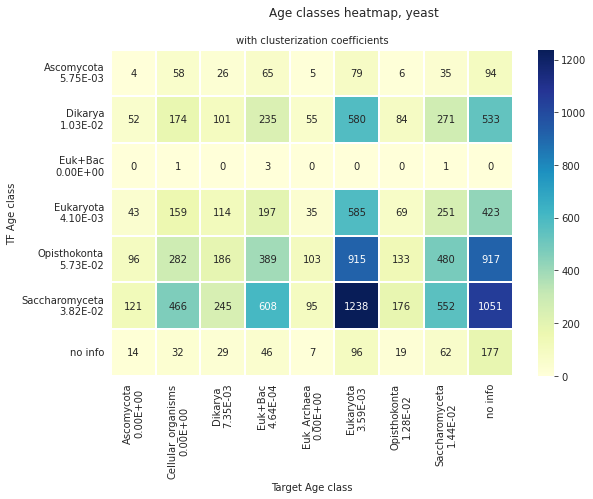

In [724]:
plt.rcParams["figure.figsize"] = 9, 6


xlabels = ['Ascomycota', 'Cellular_organisms', 'Dikarya', 'Euk+Bac', 'Euk_Archaea',
           'Eukaryota', 'Opisthokonta', 'Saccharomyceta'] # labels for x-axis

ylabels = ['Ascomycota', 'Dikarya','Euk+Bac', 
           'Eukaryota', 'Opisthokonta', 'Saccharomyceta'] # labels for y-axis

x_axis_labels = []
y_axis_labels = []

for label in xlabels:
    coeff = clustering_table[(clustering_table['organism'] == 'yeasts') 
                             & (clustering_table['class'] == label)
                             & (clustering_table['type'] == 'TG')].clust_coefficient.values[0]

    x_axis_labels.append(f'{label}\n{coeff:.2E}')
    
x_axis_labels.append('no info')
    
for label in ylabels:
    coeff = clustering_table[(clustering_table['organism'] == 'yeasts') 
                             & (clustering_table['class'] == label)
                             & (clustering_table['type'] == 'TF')].clust_coefficient.values[0]

    y_axis_labels.append(f'{label}\n{coeff:.2E}')

y_axis_labels.append('no info')

s = sns.heatmap(heatmap_y,
                xticklabels=x_axis_labels, 
                yticklabels=y_axis_labels,
                annot=True, 
                fmt='g', 
                cmap="YlGnBu",
                linewidths=1.5)

s.set(xlabel='Target Age class', ylabel='TF Age class')
#plt.setp(s.get_xticklabels(), rotation=70)

plt.suptitle('Age classes heatmap, yeast')
plt.title('with clusterization coefficients', size=10)

Text(0.5, 1.0, 'with clusterization coefficients')

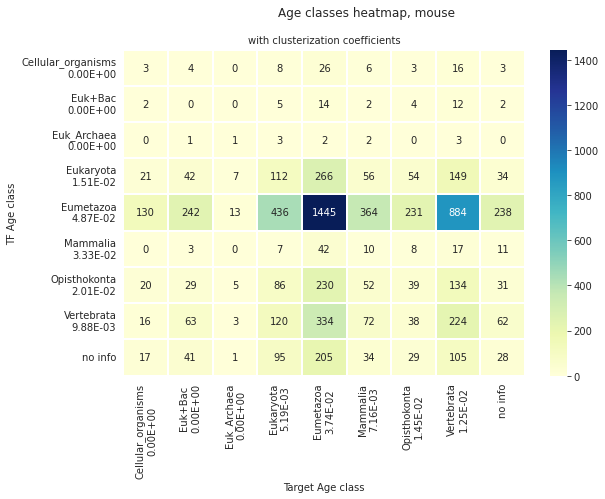

In [723]:
plt.rcParams["figure.figsize"] = 9, 6


xlabels = ['Cellular_organisms', 'Euk+Bac', 'Euk_Archaea', 'Eukaryota',
           'Eumetazoa', 'Mammalia', 'Opisthokonta', 'Vertebrata'] # labels for x-axis

ylabels = ['Cellular_organisms', 'Euk+Bac', 'Euk_Archaea', 'Eukaryota',
           'Eumetazoa', 'Mammalia', 'Opisthokonta', 'Vertebrata'] # labels for y-axis

x_axis_labels = []
y_axis_labels = []

for label in xlabels:
    coeff = clustering_table[(clustering_table['organism'] == 'mouse') 
                             & (clustering_table['class'] == label)
                             & (clustering_table['type'] == 'TG')].clust_coefficient.values[0]

    x_axis_labels.append(f'{label}\n{coeff:.2E}')
    
x_axis_labels.append('no info')
    
for label in ylabels:
    coeff = clustering_table[(clustering_table['organism'] == 'mouse') 
                             & (clustering_table['class'] == label)
                             & (clustering_table['type'] == 'TF')].clust_coefficient.values[0]

    y_axis_labels.append(f'{label}\n{coeff:.2E}')

y_axis_labels.append('no info')

s = sns.heatmap(heatmap_m,
                xticklabels=x_axis_labels, 
                yticklabels=y_axis_labels,
                annot=True, 
                fmt='g', 
                cmap="YlGnBu",
                linewidths=1.5)

s.set(xlabel='Target Age class', ylabel='TF Age class')
#plt.setp(s.get_xticklabels(), rotation=70)

plt.suptitle('Age classes heatmap, mouse')
plt.title('with clusterization coefficients', size=10)

Text(0.5, 1.0, 'with clusterization coefficients')

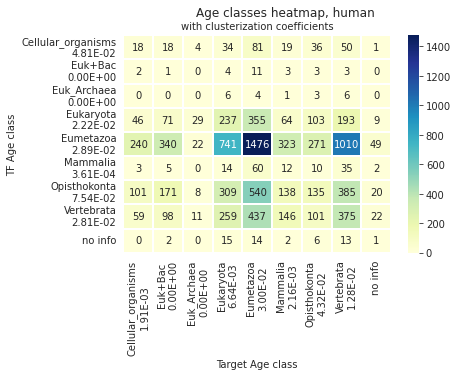

In [725]:
plt.rcParams["figure.figsize"] = 6, 4


xlabels = ['Cellular_organisms', 'Euk+Bac', 'Euk_Archaea', 'Eukaryota',
           'Eumetazoa', 'Mammalia', 'Opisthokonta', 'Vertebrata'] # labels for x-axis

ylabels = ['Cellular_organisms', 'Euk+Bac', 'Euk_Archaea', 'Eukaryota',
           'Eumetazoa', 'Mammalia', 'Opisthokonta', 'Vertebrata'] # labels for y-axis

x_axis_labels = []
y_axis_labels = []

for label in xlabels:
    coeff = clustering_table[(clustering_table['organism'] == 'human') 
                             & (clustering_table['class'] == label)
                             & (clustering_table['type'] == 'TG')].clust_coefficient.values[0]

    x_axis_labels.append(f'{label}\n{coeff:.2E}')
    
x_axis_labels.append('no info')
    
for label in ylabels:
    coeff = clustering_table[(clustering_table['organism'] == 'human') 
                             & (clustering_table['class'] == label)
                             & (clustering_table['type'] == 'TF')].clust_coefficient.values[0]

    y_axis_labels.append(f'{label}\n{coeff:.2E}')

y_axis_labels.append('no info')

s = sns.heatmap(heatmap_h,
                xticklabels=x_axis_labels, 
                yticklabels=y_axis_labels,
                annot=True, 
                fmt='g', 
                cmap="YlGnBu",
                linewidths=1.5)

s.set(xlabel='Target Age class', ylabel='TF Age class')
#plt.setp(s.get_xticklabels(), rotation=70)

plt.suptitle('Age classes heatmap, human')
plt.title('with clusterization coefficients', size=10)